# Tracking muons with Drift Tubes chambers



The aim of the project is to analyze calibration data obtained for a fixed-target beam experiment through the use of four drift-tube detectors. 
In particular, the experiment is performed in order to study the $e^+ + e^- \to \mu^+ + \mu^-$ process, through the use of a 45 GeV positrons beam impinging on a Berillium target. After the Berillium target a dipole magnet is used to deflect the trajectories, according to the sign of particle charges (positive or negative muons). Four muon drift-tubes detectors are then placed after the magnet outside the magnetic field, two for each side.

Before performing the experiment, calibration runs are taken with a beam of positive muons at a given energy. 
Varying the energy of the beam and the sign and value of the current on the magnet, different tracks are revealed on both sides of the experiment. 
In the following table the parameter values for each run are presented: 

| Run |  Energy (GeV)|  Magnet current (A)|
|-----|:---:|:-----:|
| 260 | 22 | -580 |
| 261 | 18 | -850 |
| 262 | 18 |  850 |
| 263 | 22 |  580 |


## ASSIGNMENT

The goal of the analysis is to select and study events with muon(s) passing through the detectors in calibration runs as most of those events consist of muon tracks.

- Part 1
    * Process the data and place the hits appropriately in the global $xz$ plane (i.e. transform local to global coordinates)
    * Display (event-by-event) the four detectors, the hits and the cells where the hits are found
- Part 2
    * Select good (calibration) events by requiring hits either on the left arm (detectors 0 and 1) or on the right arm (detectors 2 and 3)
    * Perform a local linear fit of the hits in each detector for the cases where at least 3 hits in 3 different layers are found
    * Repeat the fit for each possible hit left/right combination. Exclude the combinations that physically do not make sense. Find an appropriate figure of merit to retain only the best fit and the corresponding left/right combination. Keep only the points the contribute to the best fit, and discard the others (thus solving the left/right ambiguity)
- Part 3
    * Perform a global linear fit by using the hits from the previous point with the 2 detectors in the $xz$ plane
    * Add the result of the local and global fits to the event display (you should get what is shown in the pictures above, where the dashed lines correspond to the local fits and the solid line to the global one)

 ## DATA ANALYSIS STRUCTURE AND EMPLOYED PACKAGES

The analysis performed is divided in the following steps:
- Data storage and coordinates transformation
- Events filtering and selection
- Tracks fit

In order to perform the analysis for all the data files, proper functions are defined for each section. The idea is to apply then the general function automatically to each run. 

In the following box all the Python packages used in the analysis are shown:

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from matplotlib.patches import Rectangle
from IPython.display import display
from scipy import stats, optimize
import math
import timeit

## PRELIMINARY FUNCTIONS FOR GRAPHICS

Before starting with the analysis it is useful to define a function able to plot the experimental set-up, i.e. the detectors on the _xz_ global plane together with the layers of each detector involved in the passage of the particle. For this purpose, the following two functions are defined:
- **_layers_which_det_** : takes in input a dataframe corresponding to a selected event (_df_event_sel_) and a value corresponding to the detector plotted (_which_det_, from 0 to 3), and returns 6 arrays containing the indeces of the hit layer (_layers_), the global coordinates of the hits (_xleft_, _xright_ and _z_) and the coordinates of each layer vertex (_xV_lay_, _zV_lay_)
- **_exp_setup_** : takes in input the list of event dataframes (_data_), an integer number corresponding to the event to select (_n_), the parameters useful for the plots (_xlim_, _ylim_ and the parameters of the functions to plot) and returns the figure with the plot of the experimental set-up. 




In [2]:
def layers_which_det(df_event_sel, which_det):
    
    #Dataframe for the selected detector in the selected event
    df_one_det = df_event_sel[df_event_sel["chamber"]==which_det]

    #Arrays for layers and coordinates
    layers = np.array(df_one_det["layer"]) 
    x_left = np.array(df_one_det["xleft_gl"])
    x_right = np.array(df_one_det["xright_gl"])
    z = np.array(df_one_det["z_gl"])
    
    x_wire = [] #Empty list for the coordinates of the wire for each layer
    for L,R in zip(x_left, x_right):
        mid = (L+R)/2
        x_wire.append(mid)
   
    #Arrays for the coordinates of the layers vertices
    xV_lay = np.array([(x_wire[i] - 1/2*XCELL) for i in range(len(layers))])  
    zV_lay = np.array([(z[i] - 1/2*ZCELL) for i in range(len(layers))])
    
    return layers, x_left, x_right, z, xV_lay, zV_lay
    


def exp_setup(data, n, xlim, ylim, m1=0,q1=0, m2=0,q2=0, mtot=0,qtot=0, dimfigx = 20, dimfigy = 12):

    fig, ax = plt.subplots(figsize=(dimfigx,dimfigy))
    ax.set_xlim(xlim[0], xlim[1])
    ax.set_ylim(ylim[0], ylim[1])
    if(xlim[0]==-1000 and xlim[1]==1000):
        ax.set_title(f"Event {n}", fontsize=16, fontweight="bold")
    else:
        ax.set_title(f"Event {n} - zoom", fontsize=16, fontweight="bold")    
    ax.set_xlabel("Global x coordinate [mm]", fontsize=14)
    ax.set_ylabel("Global z coordinate [mm]", fontsize=14)

    det_length = 710 #mm

    x_vertex = np.array([(global_x_shifts[i]-det_length) for i in range(4)])
    z_vertex = np.array([(global_z_shifts[i]) for i in range(4)])

    #Detectors
    for i in range(4):
        det = ax.add_patch(Rectangle((x_vertex[i], z_vertex[i]), det_length, ZCELL*4, fill=False))

    #Event selection
    sel_event = data[n]
    sel_event = sel_event.sort_values(by=["chamber","layer"])
    
    #Layers and hits
    for i in sel_event.chamber.unique():
        layers, xL, xR, z, xV_lay, zV_lay = layers_which_det(sel_event, i)
        for k in range(len(layers)):
            lay = ax.add_patch(Rectangle((xV_lay[k], zV_lay[k]), XCELL, ZCELL, fill=False))
            ax.scatter(xL[k], z[k], marker="o", c="red") 
            ax.scatter(xR[k], z[k], marker="o", c="blue")

    #Muon tracks from fit
    x = np.linspace(xlim[0],xlim[1],1000)

    if(m1!=0 and q1!=0):
        ax.plot(x, m1*x+q1, "--", color="grey", label="Local fit chamber up")
        ax.legend(prop={"size": 20})

    if(m2!=0 and q2!=0):
        ax.plot(x, m2*x+q2, "--", color="grey", label="Local fit chamber down")
        ax.legend(prop={"size": 20})

    if(mtot!=0 and qtot!=0):
        ax.plot(x, mtot*x+qtot, "-", color="black", label="Global fit")
        ax.legend(prop={"size": 20})

    
    display(fig)
    plt.close()

   
    return fig, ax


## DATA STORAGE AND COORDINATE TRANSFORMATION

Each detector is divided in four layers of drift-tubes, each being a cell filled with a mixture of gas. Each cell contains an anodic wire in the center and cathods on the side. The information that one is able to gain from the cell is the time needed by charge carriers to reach the anode wire after the muon has interacted and ionized the gas. 
The position of interaction inside the cell is then found knowing that the drift velocity of particles inside the cell is constant. These informations though, are not enough to know in which side of the wire the muon has interacted, leading to a left-right ambiguity in the determination of the coordinates. 

The coordinates of the hits left by the muon on the layers are saved in the local reference frame, i.e. the intrinsic system defined for each detector. In order to generalize the problem it is necessary to pass to global coordinates, where the global reference frame is the laboratory frame. 

In the following block the dimensions of each detector cell and the coordinates transformations for the change in reference frame are given. 


In [3]:
# Cell dimensions
XCELL = 42. #mm
ZCELL = 13. #mm

# X coordinates translation
global_x_shifts = [994.2, 947.4, -267.4, -261.5,] #mm

# Z coordinates translations
local_z_shifts = [z * ZCELL for z  in range(0, 4)]
global_z_shifts = [823.5, 0., 823.5, 0.] #mm

Each run data file contains one raw for each recorded event; every event contains the coordinates of the corresponding hits(event number, number of recorded hits, coordinates for each hit). In particular, the coordinates of each hit are: chamber, layer, xleft, xright, time.


The following function opens the chosen data file, loads the events in a list of dataframes and performs the coordinate transformations needed to obtain global coordinates.

The geometry of the system and of the reference frames is the following:
- Origin of local coordinates: down left
- Origin of local coordinates in global reference frame: up right
In order to pass from local to global coordinates, the following transformations are performed:
- Along x: 180° rotation (x_local -> - x_local) and translation based on the detector position (global_x_shifts)
- Along z: 180° rotation (z_local -> - z_local), translation by four cells towards positive z (needed to have all positive global z coordinates, as in the provided picture) and translation based on the detector position (global_z_shifts)



**Convention**: 

_Left_ and _Right_, _Up_ and _Down_  are defined in the global reference frame.



In [4]:
def read_data(input_file):
    events=[] #List of dataframes; each Dataframe is one event
    with open(input_file) as infile:
        for row in infile: 
            #Read the input file row by row:
            #Each row is a string and corresponds to one event
            #Load in one dataframe all the data contained in a row, casting characters to float
            #Characters corresponding to different numbers are separated using split(), with whitespace as separating element
            row_array = np.array(list(float(temp) for temp in row.split()))
            event_index = row_array[0] #First element: index of the event
            nh=int(row_array[1]) #Second element: number of hits in the selected event
            if(nh!=0): #Neglect "events" with no hits
                
                event=pd.DataFrame(np.reshape(row_array[2:],(nh,5))) #From the third element: hits coordinates (five coordinates for each hit)
                event.columns = ["chamber","layer","xleft_loc","xright_loc","time"] #Column titles, according to data structure
                
                event["chamber"] = event["chamber"].astype(int) #Cast to int the elements of the columns "chamber" e "layer"
                event["layer"] = event["layer"].astype(int)
                
                event["z_loc"] = [(-ZCELL/2 + ZCELL*z) for z in event["layer"]]
                
                #Calculate and add all the corresponding global coordinates
                event["z_gl"] =   -event["z_loc"]+ 4*ZCELL + [global_z_shifts[i] for i in event["chamber"]] 
                event["xleft_gl"] = - event["xleft_loc"] + [global_x_shifts[i] for i in event["chamber"]]
                event["xright_gl"] = - event["xright_loc"] + [global_x_shifts[i] for i in event["chamber"]]
                
                events.append(event)
        print("Events successfully stored in list of DataFrames") 
        print("Total number of events: ", len(events)) 
    return events
            
            

input_file = "data_run260.txt"                 
events = read_data(input_file)




Events successfully stored in list of DataFrames
Total number of events:  4833


Example of dataframe structure and plot of the corresponding event 

Event 5: 

   chamber  layer  xleft_loc  xright_loc   time  z_loc   z_gl  xleft_gl  \
0        2      1      98.47      111.50  121.0    6.5  869.0   -365.87   
1        2      3      99.63      110.40  100.0   32.5  843.0   -367.03   
2        2      2     111.80      140.20  263.0   19.5  856.0   -379.20   
3        2      4     111.40      140.60  271.0   45.5  830.0   -378.80   
4        3      2      76.97       91.03  130.0   19.5   32.5   -338.47   
5        3      4      74.64       93.36  174.0   45.5    6.5   -336.14   
6        3      3      50.10       75.90  240.0   32.5   19.5   -311.60   

   xright_gl  
0    -378.90  
1    -377.80  
2    -407.60  
3    -408.00  
4    -352.53  
5    -354.86  
6    -337.40  


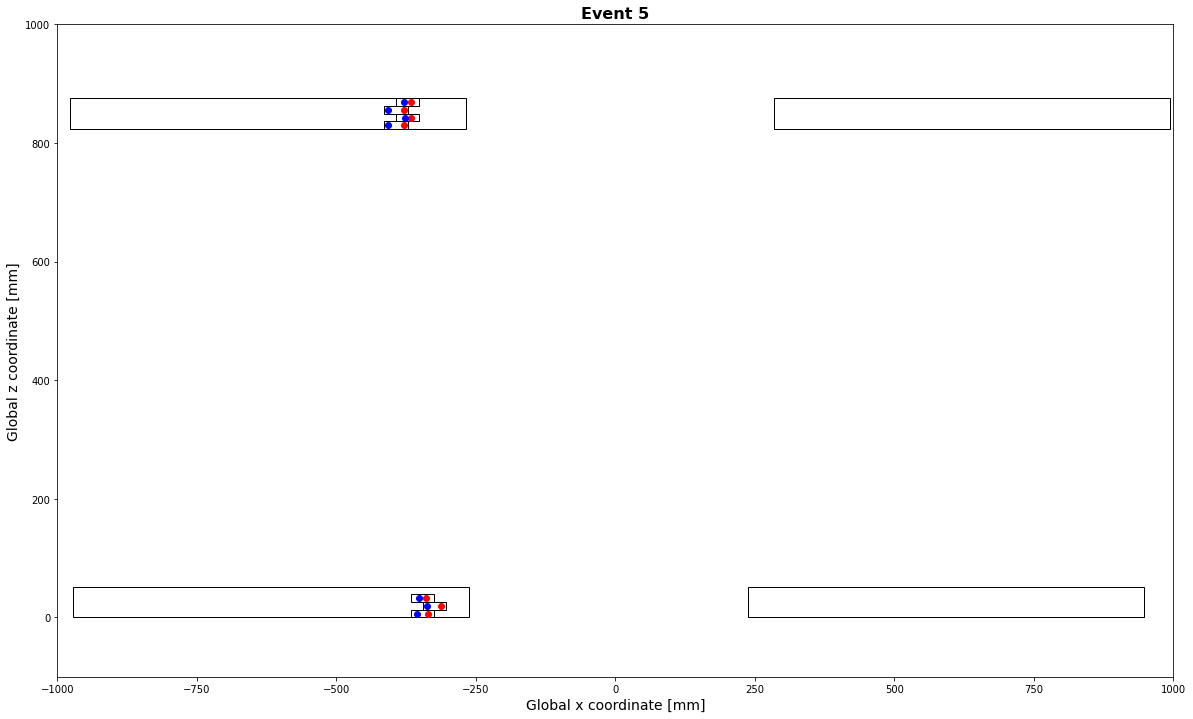

In [5]:
evt_number = 5

print("Example of dataframe structure and plot of the corresponding event \n")
print(f"Event {evt_number}: \n")

print(events[evt_number])

fig, ax = exp_setup(events, evt_number, [-1000, 1000], [-100, 1000])

## EVENTS FILTERING AND SELECTION

Since the signals come from a monoenergetic muon beam deflected by a constant magnetic field (for each run), we expect the good signal events to have the following characteristics:

- **Hits either in the two detectors on the left (0,1) or in the two detectors on the right (2,3).** 

    Events with no hits, with hits in only one detector, with hits in more than two detectors and with hits in two non-aligned detectors must be discarded. <font color="blue"> [event_filtering_1] </font>
    

- **Only one hit per layer.**

    The track of the muon is nearly orthogonal to the detectors, so signals with multiple hits in different points of a single layer must be discarded. <font color="blue"> [event_filtering_2] </font>
    
    Moreover, since we need to perform a fit of the hits in order to reconstruct the tracks, we discard also events having less than three hit layers per detector.  <font color="blue"> [event_filtering_3] </font>

- **All on the same side (left or right)**

    For each run, the orientation and strength of the magnetic field is constant; the beam used for calibration runs contains muons of the same charge. Therefore, all the muons are deflected in the same direction: either on the left or on the right side with respect to the original beam direction. <font color="blue"> [event_filtering_4] </font>

- **All in the same _x_ region**

    The beam is monoenergetic, so all the muons face the same deflection in the magnetic field. 
    Therefore they will all cross the detectors nearly in the same point, along _x_. <font color="blue"> [event_filtering_5] </font>


Signals having these characteristics look like event showed in the plot above.


We will now proceed to the filtering of the dataset, in order to retain only good signal events.


In [6]:
def event_filtering1(data): #I keep only events with hits in two aligned chambers

    good_events=[] 

    chambers_right= np.array([0,1])
    chambers_left = np.array([2,3])

    good_events= [df for df in data if 
                  ((np.array_equal(df.chamber.unique(), chambers_left)) 
                   or np.array_equal(df.chamber.unique(), chambers_right))]  

    print("Event filtering - step 1:")
    print("Number of events with hits only in two aligned detectors (left OR right):", len(good_events), "\n")  
    return good_events

good_events1= event_filtering1(events)


Event filtering - step 1:
Number of events with hits only in two aligned detectors (left OR right): 2868 



Example of events filtered out in step 1: 



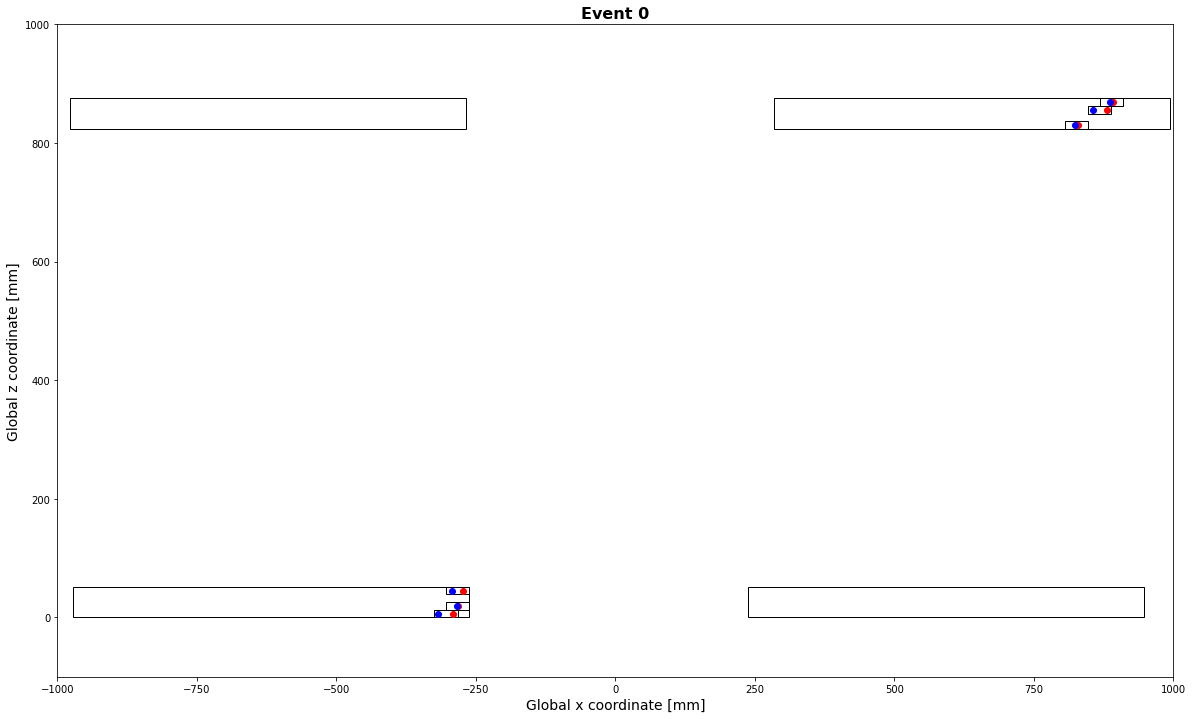

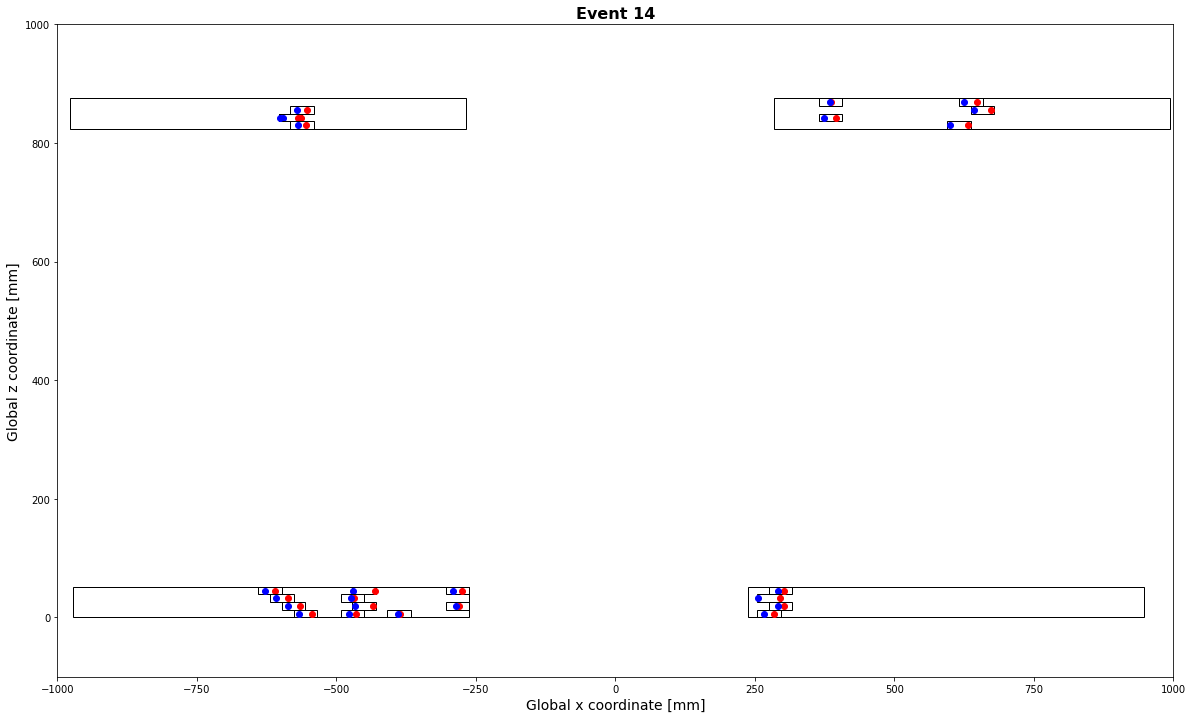

In [7]:
print("Example of events filtered out in step 1: \n")
evt_number = 0
fig, ax = exp_setup(events, evt_number, [-1000, 1000], [-100, 1000])

evt_number = 14
fig, ax = exp_setup(events, evt_number, [-1000, 1000], [-100, 1000])

In [8]:
def event_filtering2(data): #I keep only events without multiple hits per layer
    
    good_events = []
    for i in range(len(data)):
        grouped = data[i].groupby("chamber")
        is_good = True
        for key,item in grouped:
            if(item["layer"].duplicated().any()):
                is_good = False
                break
        if(is_good):
            good_events.append(data[i])

    print("Event filtering - step 2:")
    print("Number of events without multiple hits per layer:", len(good_events), "\n")  
    
    return good_events


good_events2=event_filtering2(good_events1)


Event filtering - step 2:
Number of events without multiple hits per layer: 1767 



Example of events filtered out in step 2: 



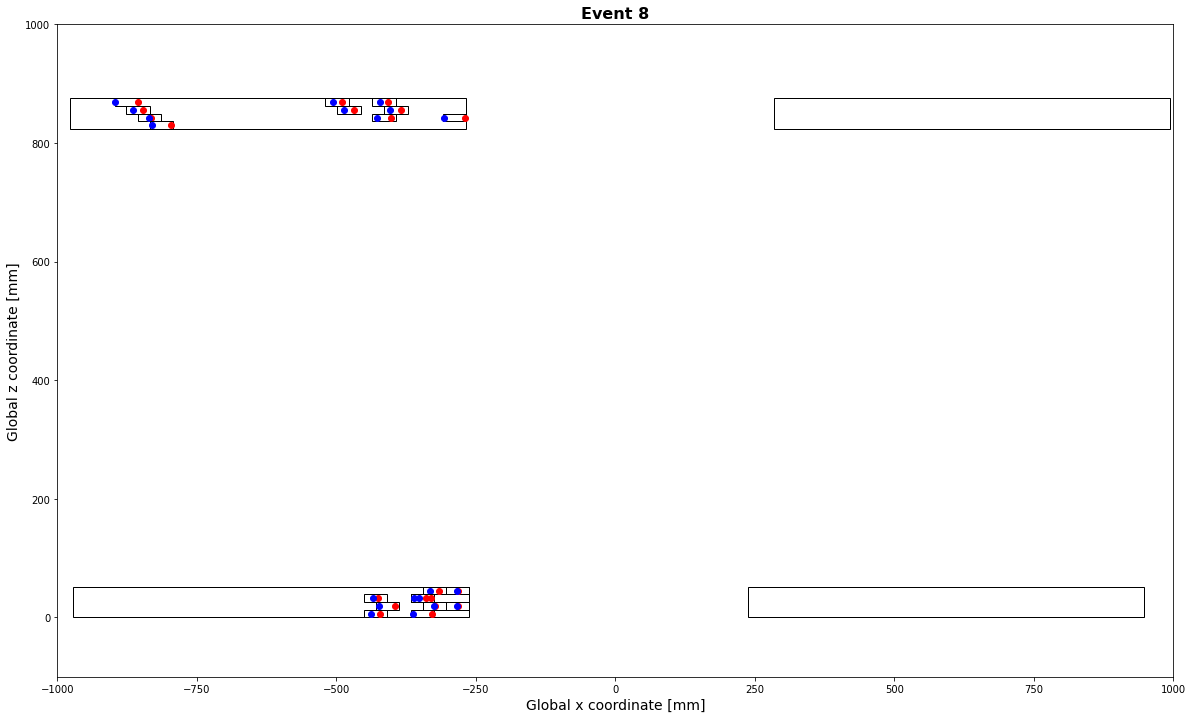

In [9]:
print("Example of events filtered out in step 2: \n")
evt_number = 8
fig, ax = exp_setup(events, evt_number, [-1000, 1000], [-100, 1000])

In [10]:
def event_filtering3(data): #I keep only events with at least 3 hit layers per detector
    
    good_events = [df for df in data if (df.groupby(["chamber"]).size() >=3).all()]
    
    print("Event filtering - step 3:")
    print("Number of events with at least 3 hit layers for each detector:", len(good_events), "\n")
    
    return good_events

good_events3= event_filtering3(good_events2)



Event filtering - step 3:
Number of events with at least 3 hit layers for each detector: 1457 



The following functions are developed in order to select the correct orientation of the tracks corresponding to those events hitting only the detectors on one side of the plane. The aim is therefore to select the pair of detectors (0-1 or 2-3) where there is a larger number of events with respect to the other two. 

The selection is realized first comparing the net number of events on both sides and then showing graphically the distribution of events. 
To do so, the following function is introduced:
- **_event_filtering4_** : takes in input the events dataframes list (_data_) and returns in output the final dataframes list for the selected events (_final_events_) and the index corresponding to detector up and down (_chamber_up_, _chamber_down_).



Event filtering - step 4:
Number of events on the left arm:  1363
Number of events on the right arm:  94
The maximum is on the left, so we reject events on detectors 0 and 1
The number of events on the left is indeed  14.5  times larger than the number of events on the right 

For this run: 
 - Detector up:  2 
 - Detector down:  3 



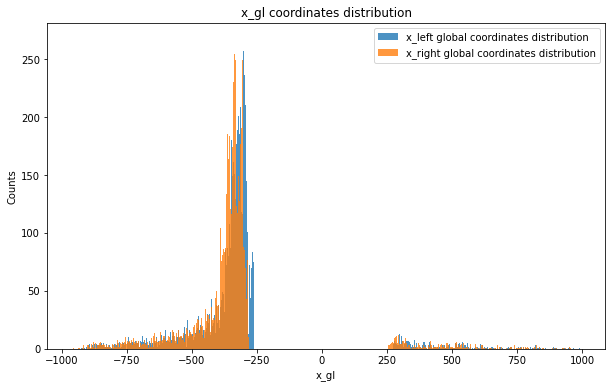

In [11]:
def event_filtering4(data):

    #Number of events on both sides: 
    #given the previous rejection, we assume N0 = N1 and N2 = N3
    N01 = len([df for df in data if (df["chamber"]==0).any()])
    N23 = len([df for df in data if (df["chamber"]==3).any()])

    #find the maximum and minimum between the two
    max_events = max(N01, N23)
    min_events = min(N01, N23)

    print("Event filtering - step 4:")
    print("Number of events on the left arm: ", N23)
    print("Number of events on the right arm: ", N01)

    #select only one pair of detectors
    if max_events==N23:
        print("The maximum is on the left, so we reject events on detectors 0 and 1") 
        print("The number of events on the left is indeed ", format(max_events/min_events, ".1f"), " times larger than the number of events on the right \n")
        final_events = [df for df in data if ((df["chamber"]==2).any() or (df["chamber"]==3).any())]
        chamber_up = 2
        chamber_down = 3
        
    else:
        print("The maximum is on the right arm, so we reject events on detectors 2 and 3")
        print("The number of events on the right is indeed ", format(max_events/min_events, ".1f"), " times larger than the number of events on the left \n")
        final_events = [df for df in data if ((df["chamber"]==0).any() or (df["chamber"]==1).any())]
        chamber_up = 0
        chamber_down = 1
        
    print("For this run: \n - Detector up: ", chamber_up, "\n - Detector down: ", chamber_down, "\n")


    #graphical visualization
    df_det01 = pd.concat([df for df in data if ((df["chamber"]==0).any() or (df["chamber"]==1).any())])
    df_det23 = pd.concat([df for df in data if ((df["chamber"]==2).any() or (df["chamber"]==3).any())])
    
    x_left_det23 = np.array(df_det23["xleft_gl"])
    x_left_det01 = np.array(df_det01["xleft_gl"])
    x_gl_left = np.concatenate((x_left_det23, x_left_det01))
        
    x_right_det23 = np.array(df_det23["xright_gl"])
    x_right_det01 = np.array(df_det01["xright_gl"])
    x_gl_right = np.concatenate((x_right_det23, x_right_det01))

    #events distribution
    fig, ax = plt.subplots(figsize=(10,6))
    ax.set_title("x_gl coordinates distribution")
    ax.set_xlabel("x_gl")
    ax.set_ylabel("Counts")
    h1, bins1, _ = plt.hist(x_gl_left, bins=1000, alpha=0.8, label="x_left global coordinates distribution")
    h2, bins2, _ = plt.hist(x_gl_right, bins=1000, alpha=0.8, label="x_right global coordinates distribution")
    plt.legend()
    display(fig)
    plt.close()
    
    return final_events, chamber_up, chamber_down

good_events4, det_up, det_down = event_filtering4(good_events3)




The last rejection is performed considering that for the same calibration run all the good tracks should distribute around a constant value of the _x_ coordinate. In order to look at the overall distribution of events, an histogram of the _global x_ coordinates is realized, for both the detector in the up and down position. The good events are then selected as those whose _x global_ coordinates do not fall outside the Gaussian distribution range (i.e. events in the range [$\mu$ - 5$\sigma$, $\mu$ + $\sigma$], where $\mu$ is the centroid of the distribution and $\sigma$ is its standard deviation). 

For this purpose the following function is introduced:
- **_event_filtering5_** : takes in input the events dataframes list (_data_), the index representing detectors up and down (_det_up_, _det_down_) and the initialization of the parameters for the Gaussian fit function (_p1_, _p2_), which depend on the data file under analysis. The function returns then the list of dataframes for the final selected events (_final_data_) and the value of the centroids estimated through the Gaussian fit, both for the detector up and down (_centr_up_, _centr_down_).

Event filtering - step 5:
Parameters fit function detector up: 
 Amplitude =  169.09 
 Sigma =  35.34 
 Centroid =  -347.37 


Parameters fit function detector down: 
 Amplitude =  180.06 
 Sigma =  29.91 
 Centroid =  -307.97 




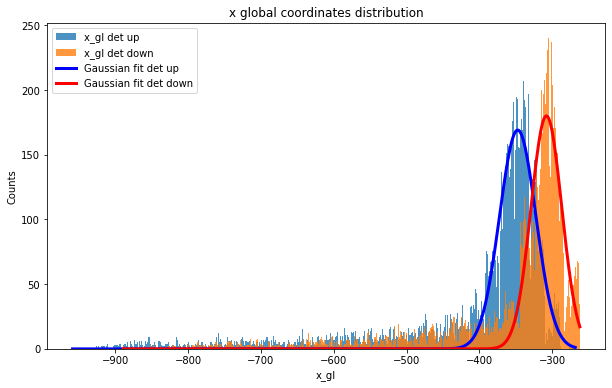

Number of events within 5sigma from the center of the distributions:  1054


In [12]:
#parameters initialization for Gaussian fits
p1 = [250, 100, -300]
p2 = [200, 100, -350]

#Gaussian distributions of events and fit
def event_filtering5(data, det_up, det_down, p1, p2):
    total_df = pd.concat(data)
    df_det_up = total_df[total_df["chamber"]==det_up]
    df_det_down = total_df[total_df["chamber"]==det_down]
    x_gl_up = np.concatenate((df_det_up["xleft_gl"].to_numpy(), df_det_up["xright_gl"].to_numpy()))
    x_gl_down = np.concatenate((df_det_down["xleft_gl"].to_numpy(), df_det_down["xright_gl"].to_numpy()))
    
    fig, ax = plt.subplots(figsize=(10,6))
    ax.set_title("x global coordinates distribution")
    ax.set_xlabel("x_gl")
    ax.set_ylabel("Counts")
    h1, bins1, _ = plt.hist(x_gl_up, bins=500, alpha=0.8, label="x_gl det up") 
    h2, bins2, _ = plt.hist(x_gl_down, bins=500, alpha=0.8, label="x_gl det down")
    
    
    #define a fit function: Gaussian function
    def f(x, A, sigma, mu):
        return A*np.exp(- ((x - mu)/sigma)**2)
    
    bins_centers1 = np.array([0.5 * (bins1[i] + bins1[i+1]) for i in range(len(bins1)-1)])
    bins_centers2 = np.array([0.5 * (bins2[i] + bins2[i+1]) for i in range(len(bins2)-1)])
    
    popt1, pcov1 = optimize.curve_fit(f, bins_centers1, h1, p0=p1, full_output=False)
    popt2, pcov2 = optimize.curve_fit(f, bins_centers2, h2, p0=p2, full_output=False)

    amp_up = popt1[0]
    sigma_up = popt1[1]
    centr_up = popt1[2]
    amp_down = popt2[0]
    sigma_down = popt2[1]
    centr_down = popt2[2]

    print("Event filtering - step 5:")
    print("Parameters fit function detector up: \n", 
          "Amplitude = ", format(amp_up, ".2f"), "\n Sigma = ", format(sigma_up, ".2f"), "\n Centroid = ", format(centr_up, ".2f"), "\n\n")
    
    print("Parameters fit function detector down: \n", 
          "Amplitude = ", format(amp_down, ".2f"), "\n Sigma = ", format(sigma_down, ".2f"), "\n Centroid = ", format(centr_down, ".2f"), "\n\n")
  

    plt.plot(bins1, f(bins1, popt1[0], popt1[1], popt1[2]), color="blue", linewidth=3, label="Gaussian fit det up")
    plt.plot(bins2, f(bins2, popt2[0], popt2[1], popt2[2]), color="red", linewidth=3, label="Gaussian fit det down")
    plt.legend(loc="best")
    display(fig)
    plt.close()
    

      
    final_data = []
    for i in range(len(data)):
        fin = data[i]
        fin2 = fin[(fin["xleft_gl"]> (centr_up-5*sigma_up)) & (fin["xleft_gl"]< (centr_up+5*sigma_up)) &
                (fin["xright_gl"]> (centr_up-5*sigma_up)) & (fin["xright_gl"]< (centr_up+5*sigma_up)) & 
                (fin["xleft_gl"]> (centr_down-5*sigma_down)) & (fin["xleft_gl"]< (centr_down+5*sigma_down)) &
                (fin["xright_gl"]> (centr_down-5*sigma_down)) & (fin["xright_gl"]< (centr_down+5*sigma_down))]
        if (len(fin2) == len(fin)):
                final_data.append(fin2)
        
    
        


    print("Number of events within 5sigma from the center of the distributions: ", len(final_data))
    
    return final_data, centr_up, centr_down


good_events5, centr_up, centr_down = event_filtering5(good_events4, det_up, det_down, p1, p2)






In [13]:
best_events=good_events5

Considering the centroids of the previous Gaussian distributions, it is also possible to estimate the mean angle of deflection of the trajectory of the crossing muon, as presented in the following function.

In [14]:
def deflection_angle(centr_up, centr_down):
    H = global_z_shifts[0] #distance between the detectors along z axis
    delta = abs(centr_up - centr_down)

    #Angle with respect to z-axis
    theta_z = np.arctan(delta/H)
    
    print("Angle of incidence of the track with respect to z axis: ", format((theta_z*180)/math.pi, ".2f"), "°")

    return theta_z
  

theta_z = deflection_angle(centr_up, centr_down)

Angle of incidence of the track with respect to z axis:  2.74 °


## TRACKS FIT 

It is now possible to perform the track reconstruction of the selected events.

After coming out from the magnetic field, the muon travels in a straight line crossing the two aligned detectors.
The goal of this section is to reconstruct its trajectory by performing a fit of the experimental hits.

Two methods will be presented and compared: 

1. **Local optimization of the track (1.1) and global fit of the resulting points (1.2)**
2. **Global optimization of the track**





In [15]:
def fit_funct(t, m,q):
        return m*t+q

### 1.1 Local optimization of the track

The hits in the two detectors are considered separately.

First of all, all the possible combinations of one coordinate (left or right) per hit layer are extracted.
For each hit layer, the choice is among _x left_ and _x right_: there are therefore $2^n$ possible combinations, with _n_ number of hit layers in the considered detector.

Each of these combination is fitted with a linear function.

For each fitted combination, the RSS (Residual Sum of Squares) is calculated: 
the coordinate combination leading to the minimum RSS corresponds to the actual track of the muon through the considered detector.
The left/right ambiguity of the coordinates is thus solved.


The function below performs this minimization.

Input parameters:
- _data_  
    One dataframe, corresponding to one event
    

Return parameters:
- _best_local_fits_  
    All the information about the local best fit, for each chamber.
    In particular, for each of the two detectors:
    * Detector number
    * Number of chosen combination 
    * X coordinates (global)
    * Z coordinates (global)
    * Fit parameters (slope m, intercept q)
    * Covariance matrix
    * Residual sum of squares
    




In [16]:
def find_best_combination_and_local_fit(data): 

    grouped = data.groupby("chamber")
    
    best_fits_local=[] # Results of fit optimization in the two detectors

    for key,chamber in grouped: #Analysis detector by detector
        n_layers= len(chamber["layer"])

        if (n_layers==3): #Case 3 hit layers

            possible_combinations = np.array([(x0,x1,x2) 
                            for x0 in [chamber["xleft_gl"].iloc[0],chamber["xright_gl"].iloc[0]] 
                            for x1 in [chamber["xleft_gl"].iloc[1],chamber["xright_gl"].iloc[1]]
                            for x2 in [chamber["xleft_gl"].iloc[2],chamber["xright_gl"].iloc[2]]])                           

        elif (n_layers==4): #Case 4 hit layers

            possible_combinations = np.array([(x0,x1,x2,x3) 
                            for x0 in [chamber["xleft_gl"].iloc[0],chamber["xright_gl"].iloc[0]]
                            for x1 in [chamber["xleft_gl"].iloc[1],chamber["xright_gl"].iloc[1]]
                            for x2 in [chamber["xleft_gl"].iloc[2],chamber["xright_gl"].iloc[2]]
                            for x3 in [chamber["xleft_gl"].iloc[3],chamber["xright_gl"].iloc[3]]])
  
        z=[] #For all the combinations, z coordinates are the same
        for i in range(n_layers):
            zi= chamber["z_gl"].iloc[i]
            z.append(zi)

        i=1
        best_fit_rss = math.inf # Initial value: RSS = +inf, then I minimize
        for x in possible_combinations:

            par, par_cov = optimize.curve_fit(fit_funct, x, z, full_output=False) #Linear fit
            f_of_x = fit_funct(x, par[0], par[1]) 
            rss = sum((z - f_of_x )**2) #Residual sum of squares

            if(rss < best_fit_rss):
                best_fit_rss = rss # RSS minimization

                best_fit = {"Chamber":key, "Combination":i,"x":x, "z":z, "Parameters (m,q)":par, "Covariance matrix":par_cov, "RSS":rss}

            i=i+1

        best_fits_local.append(best_fit)

    return best_fits_local 


Example: event 6

Execution time:  0.024363164993701503 s

Results: 

Chamber = 2
Combination = 4
x = [-347.29 -345.81 -347.66 -346.22]
z = [856.0, 830.0, 869.0, 843.0]
Parameters (m,q) = [  -18.83892815 -5682.80414289]
Covariance matrix = [[7.52173561e+00 2.60812421e+03]
 [2.60812421e+03 9.04358319e+05]]
RSS = 34.360842344906345


Chamber = 3
Combination = 13
x = [-309.81 -308.37 -310.65 -309.35]
z = [32.5, 6.5, 45.5, 19.5]
Parameters (m,q) = [  -17.50986968 -5394.09260881]
Covariance matrix = [[2.61202167e+00 8.08538243e+02]
 [8.08538243e+02 2.50280739e+05]]
RSS = 14.156610945063989




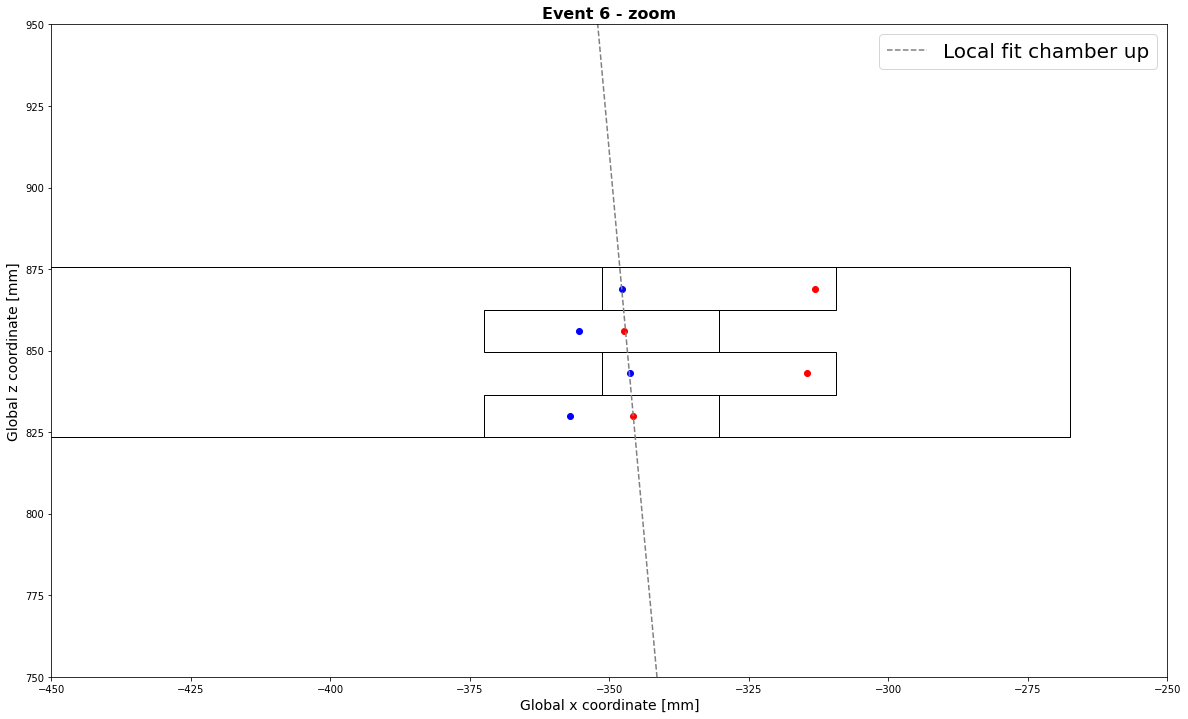

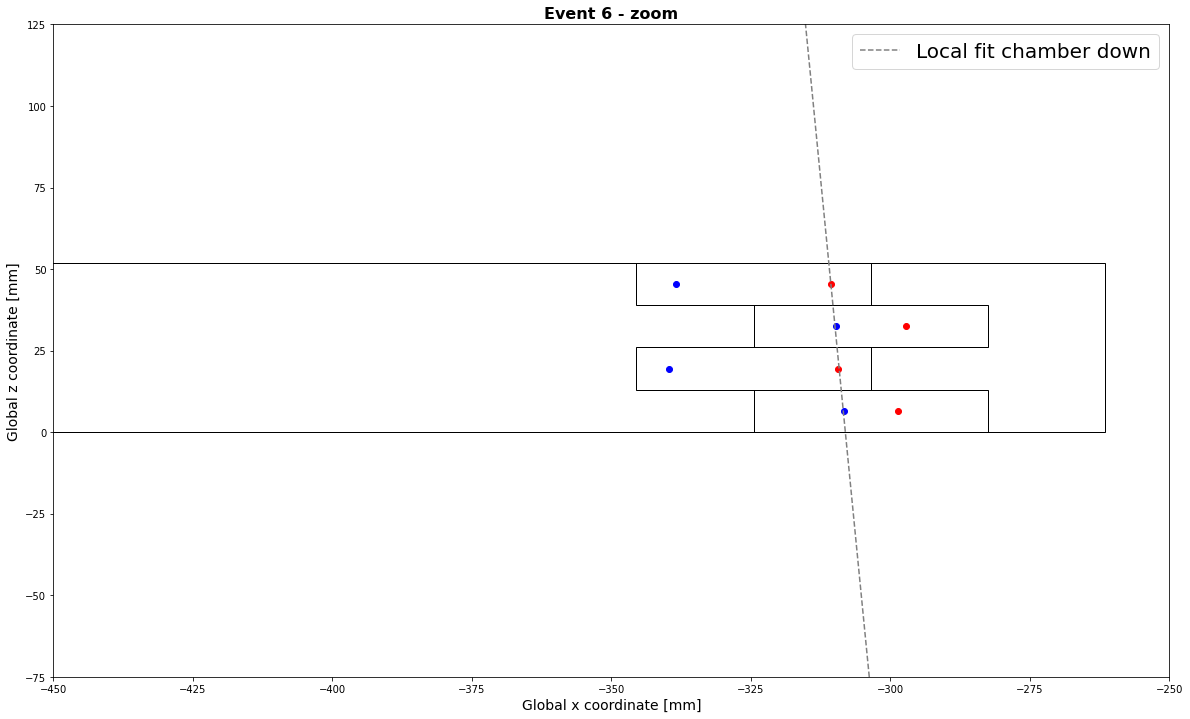

In [17]:
#Example: case in which the method works well 

evt_number=6
print(f"Example: event {evt_number}\n")
start_time = timeit.default_timer()
best_local_fits = find_best_combination_and_local_fit(best_events[evt_number])
elapsed = timeit.default_timer() - start_time
print("Execution time: ", elapsed, "s\n")

       
print("Results: \n")
for data_single_chamber in best_local_fits:
    for i in data_single_chamber:
        print(i, "=", data_single_chamber[i])
    print("\n")


m1fit=best_local_fits[0]["Parameters (m,q)"][0]
q1fit=best_local_fits[0]["Parameters (m,q)"][1]

fig, ax = exp_setup(best_events, evt_number, [-450,-250], [750,950],m1= m1fit, q1=q1fit)
        

m2fit=best_local_fits[1]["Parameters (m,q)"][0]
q2fit=best_local_fits[1]["Parameters (m,q)"][1]

fig, ax = exp_setup(best_events, evt_number, [-450,-250], [-75,125],m2= m2fit, q2=q2fit)


### 1.2 Global fit of points found via local optimization

For each detector, the optimal combination of coordinates has been previously found.

Now a global fit of these two sets of coordinate is performed, in order to reconstruct the actual track of the muon. 
The global fit is more meaningful than the two local fits, since it takes into account the constraints from the hits positions in both the detectors.

The function below performs this fit.

Input parameters:
- _data_  
    Output of the previous function (information about the two local best fits)
    

Return parameters:
- _global_fit_from_local_optimization_  
    Results of the global fit:
    * X coordinates (global)
    * Z coordinates (global)
    * Fit parameters (slope m, intercept q)
    * Covariance matrix


In [18]:

def global_fit_best_local_combs(data): 

    l=[]

    for data_single_chamber in data:

        best_track_loc = pd.DataFrame(columns = ["x_gl", "z_gl"]) 

        best_track_loc["x_gl"] = data_single_chamber["x"]
        best_track_loc["z_gl"] = data_single_chamber["z"]
        
        l.append(best_track_loc)

    data_two_chambers_from_best_local_fits = pd.concat(l)

    par, par_cov = optimize.curve_fit(fit_funct, data_two_chambers_from_best_local_fits["x_gl"], data_two_chambers_from_best_local_fits["z_gl"], full_output=False) #Linear fit
    global_fit_from_local_optimization = {"x":np.array(data_two_chambers_from_best_local_fits["x_gl"]), "z":np.array(data_two_chambers_from_best_local_fits["z_gl"]),  "Parameters (m,q)":par, "Covariance matrix":par_cov}

    return global_fit_from_local_optimization


Example: event 6

Results global fit: 

x = [-347.29 -345.81 -347.66 -346.22 -309.81 -308.37 -310.65 -309.35]
z = [856.  830.  869.  843.   32.5   6.5  45.5  19.5]
Parameters (m,q) = [  -22.12985731 -6824.05202783]
Covariance matrix = [[7.88893113e-03 2.58871332e+00]
 [2.58871332e+00 8.52207519e+02]]


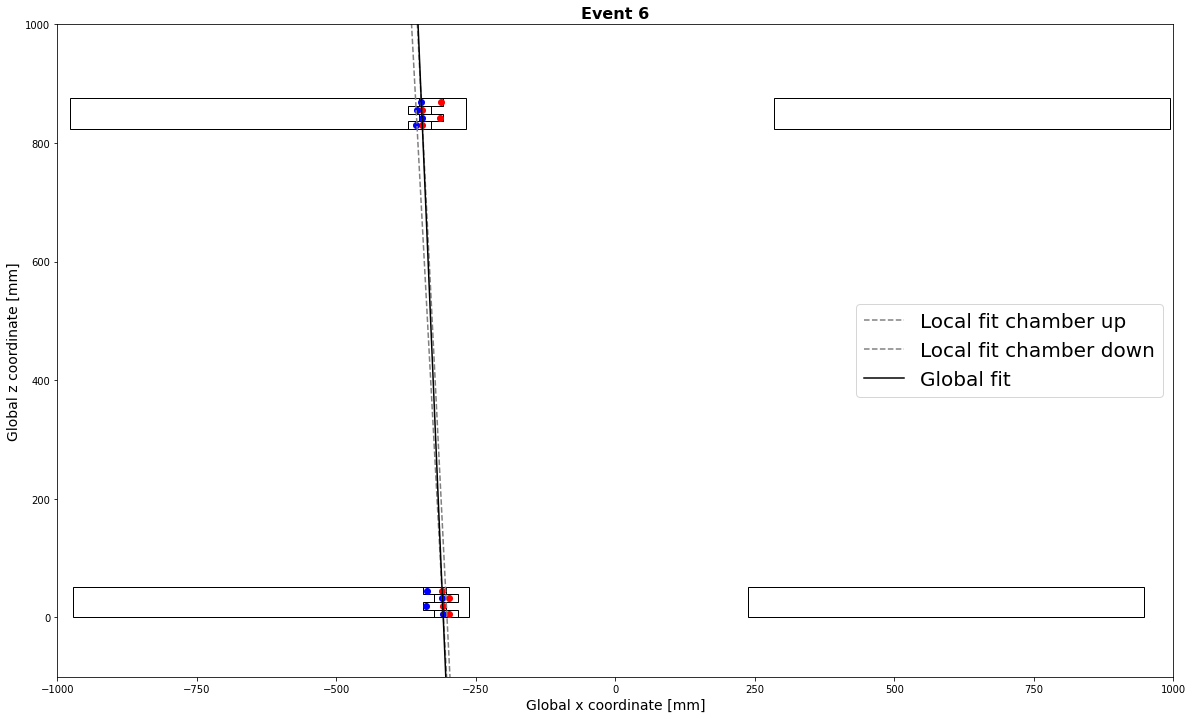

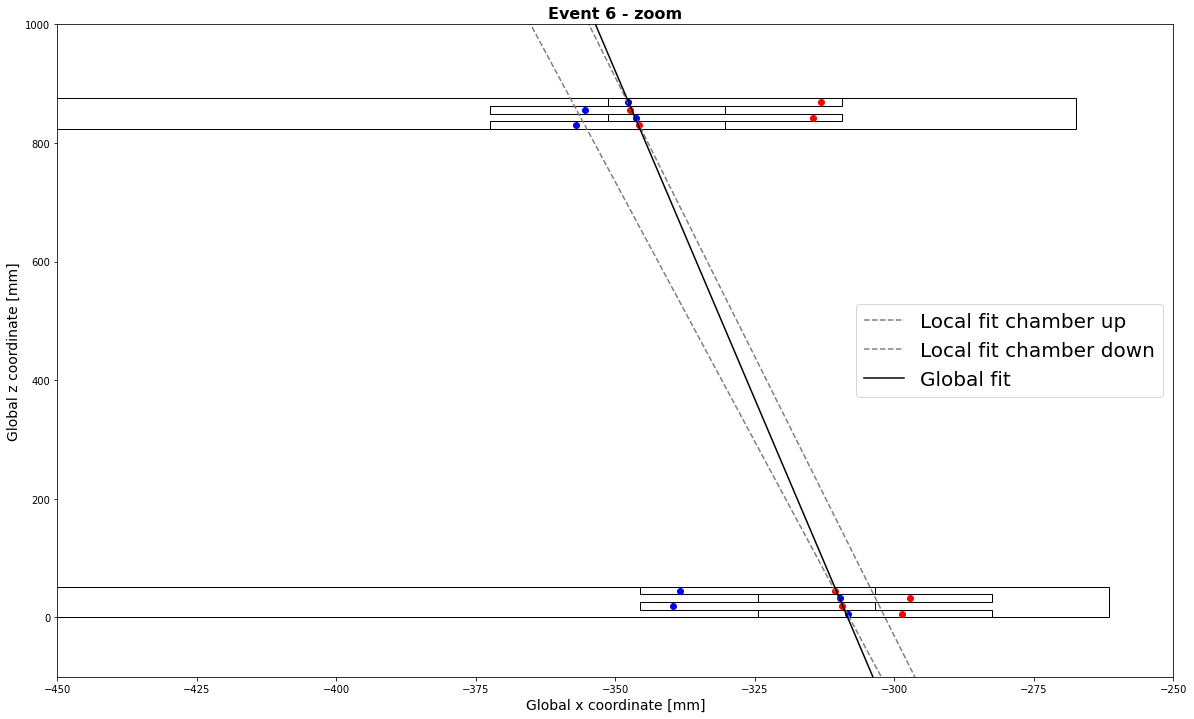

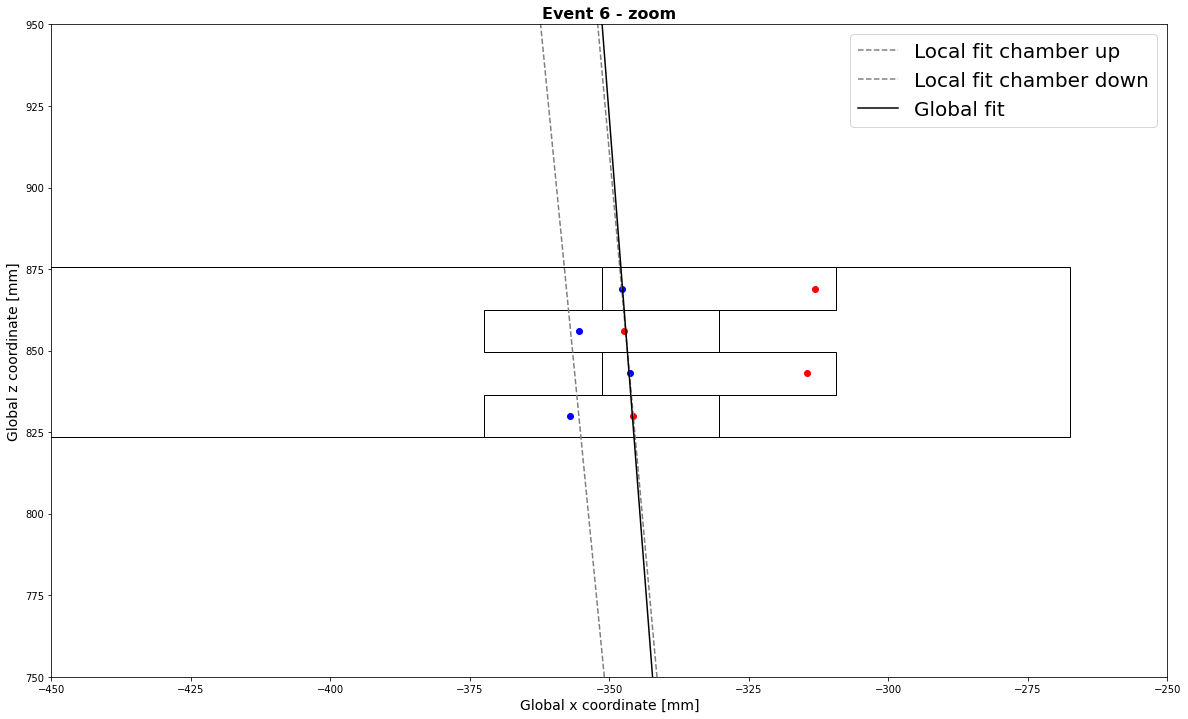

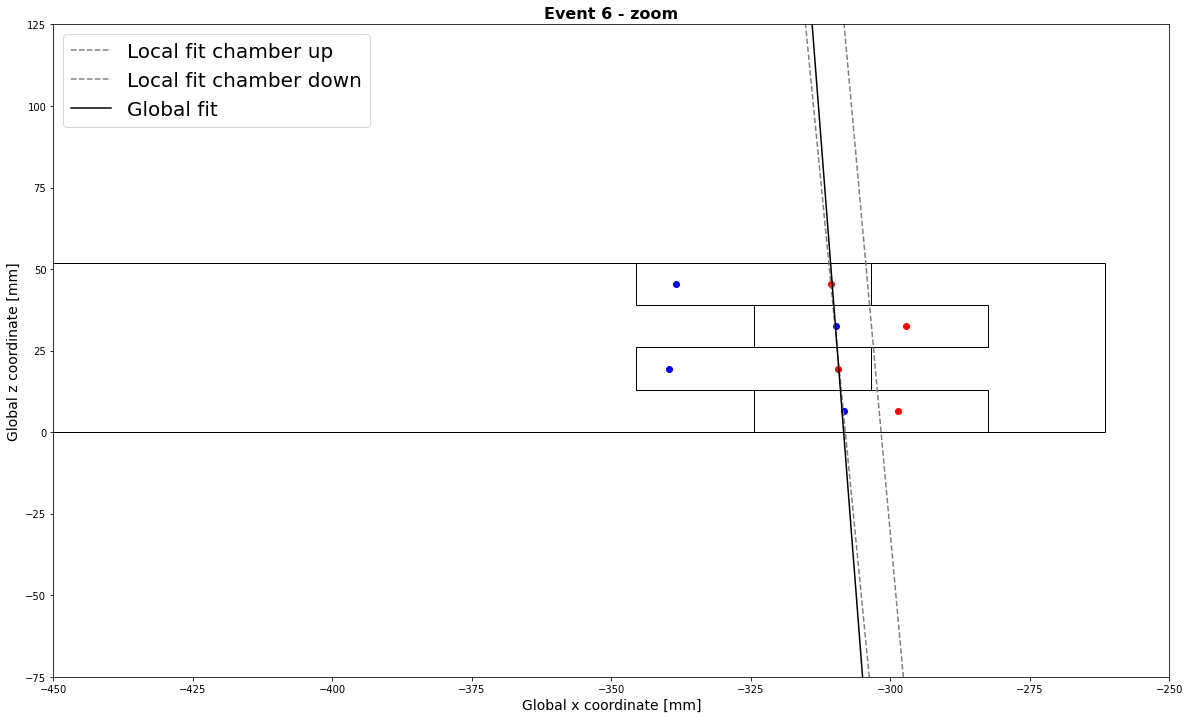

In [19]:
#Example: case in which the method works well 

print(f"Example: event {evt_number}\n")
global_fit_from_local_optimization = global_fit_best_local_combs(best_local_fits)     
print("Results global fit: \n")
for i in global_fit_from_local_optimization:
    print(i, "=", global_fit_from_local_optimization[i])
    
mtotfit=global_fit_from_local_optimization["Parameters (m,q)"][0]
qtotfit=global_fit_from_local_optimization["Parameters (m,q)"][1]

fig, ax = exp_setup(best_events, evt_number, [-1000,1000], [-100,1000],m1= m1fit, q1=q1fit, m2= m2fit, q2=q2fit, mtot=mtotfit, qtot=qtotfit  )
fig, ax = exp_setup(best_events, evt_number, [-450,-250], [-100,1000],m1= m1fit, q1=q1fit, m2= m2fit, q2=q2fit, mtot=mtotfit, qtot=qtotfit  )
fig, ax = exp_setup(best_events, evt_number, [-450,-250], [750,950],m1= m1fit, q1=q1fit, m2= m2fit, q2=q2fit, mtot=mtotfit, qtot=qtotfit  )
fig, ax = exp_setup(best_events, evt_number, [-450,-250], [-75,125],m1= m1fit, q1=q1fit, m2= m2fit, q2=q2fit, mtot=mtotfit, qtot=qtotfit  )

**Comment:**

There are case, though, in which this method does not work properly. Here is an example.

Example: event 13

Results local fits: 

Chamber = 2
Combination = 9
x = [-352.64 -351.33 -356.89 -352.81]
z = [856.0, 830.0, 869.0, 843.0]
Parameters (m,q) = [   -6.17126212 -1331.53203202]
Covariance matrix = [[5.25406316e+00 1.85687788e+03]
 [1.85687788e+03 6.56275984e+05]]
RSS = 182.73105714807852


Chamber = 3
Combination = 3
x = [-294.36 -335.12 -313.57]
z = [6.5, 45.5, 19.5]
Parameters (m,q) = [  -0.96186706 -278.52957758]
Covariance matrix = [[2.31827598e-02 7.28750050e+00]
 [7.28750050e+00 2.29725204e+03]]
RSS = 19.278817993010946




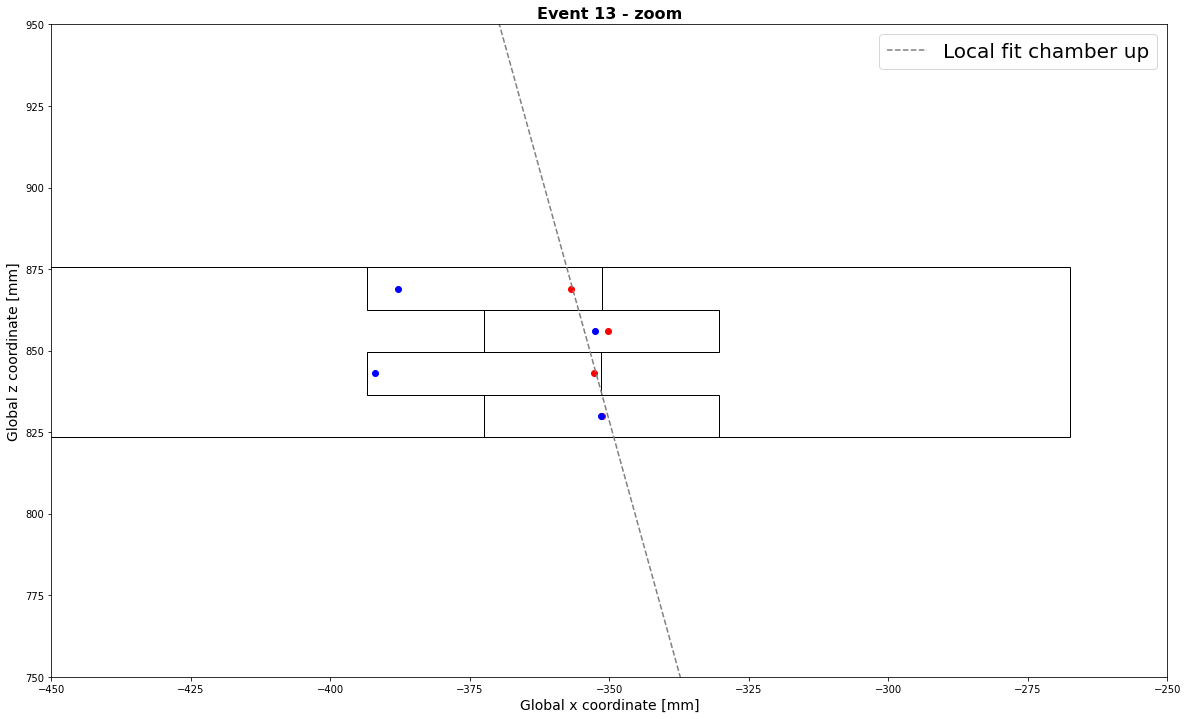

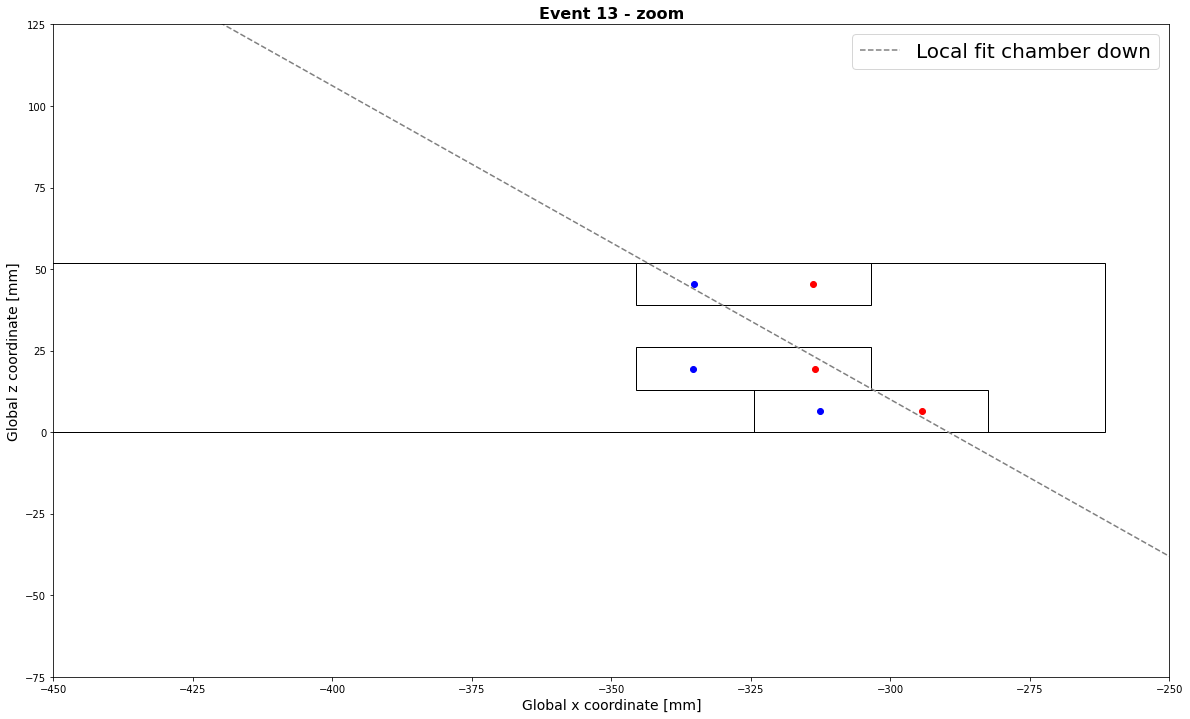

Results global fit: 

x = [-352.64 -351.33 -356.89 -352.81 -294.36 -335.12 -313.57]
z = [856.  830.  869.  843.    6.5  45.5  19.5]
Parameters (m,q) = [  -16.21850298 -4964.71005067]
Covariance matrix = [[1.49333225e+01 5.02766566e+03]
 [5.02766566e+03 1.70007870e+06]]


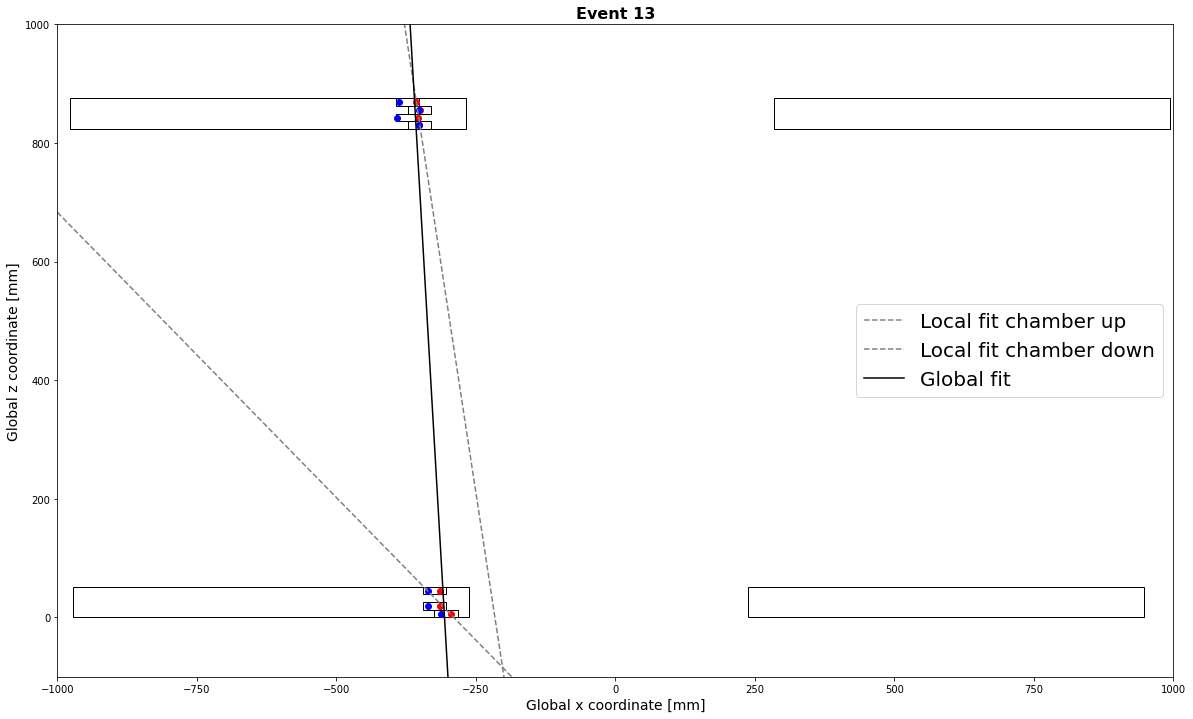

In [20]:
#Example: case in which the method does NOT work well

evt_number=13
print(f"Example: event {evt_number}\n")
best_local_fits = find_best_combination_and_local_fit(best_events[evt_number])

print("Results local fits: \n")
for data_single_chamber in best_local_fits:
    for i in data_single_chamber:
        print(i, "=", data_single_chamber[i])
    print("\n")

m1fit=best_local_fits[0]["Parameters (m,q)"][0]
q1fit=best_local_fits[0]["Parameters (m,q)"][1]

fig, ax = exp_setup(best_events, evt_number, [-450,-250], [750,950],m1= m1fit, q1=q1fit  )
        

m2fit=best_local_fits[1]["Parameters (m,q)"][0]
q2fit=best_local_fits[1]["Parameters (m,q)"][1]

fig, ax = exp_setup(best_events, evt_number, [-450,-250], [-75,125],m2= m2fit, q2=q2fit  )



global_fit_from_local_optimization = global_fit_best_local_combs(best_local_fits)     
print("Results global fit: \n")
for i in global_fit_from_local_optimization:
    print(i, "=", global_fit_from_local_optimization[i])
    
mtotfit=global_fit_from_local_optimization["Parameters (m,q)"][0]
qtotfit=global_fit_from_local_optimization["Parameters (m,q)"][1]

fig, ax = exp_setup(best_events, evt_number, [-1000,1000], [-100,1000],m1= m1fit, q1=q1fit, m2= m2fit, q2=q2fit, mtot=mtotfit, qtot=qtotfit  )




In order to avoid this possible behaviour, an alternative method is developed:

### 2 Global optimization of the track

The full track (hits in two detectors) is here considered.

All the possible combinations of one coordinate (left or right) per hit layer are extracted.
In this case there are therefore $2^n$ possible combinations, with _n_ total number of hit layers in the two detectors.
Each of these combination is fitted with a linear function and the best coordinate combination is found via RSS minimization.

Conceptually, this method can be preferred to the previous one since it considers from the beginning the constraints coming from the coordinate positions along all the trajectory. It therefore avoids the risk of extracting, locally, a non physical trajectory that accidentally has an extremely low RSS.

Instead, the drawback is that it is less efficient from the computational point of view:
when performing the local optimization, the number of hit layers is 3 or 4, meaning 9 or 16 possible coordinates combinations to deal with; when performing the global optimization, the number of hit layers is 6-8, meaning 64-256 possible combinations to fit and compare.

The execution time of the functions corresponding to the two methods will be compared, in order to evaluate their convenience.

The function below performs the global optimization and fit.

Input parameters:
- _data_  
    One dataframe, corresponding to one event
    

Return parameters:
- _best_global_fit_  
    Results of the global minimization and fit:
    * X coordinates (global)
    * Z coordinates (global)
    * Fit parameters (slope m, intercept q)
    * Covariance matrix
     * Residual sum of squares
    * Number of chosen combination 


<font color = "red">



In [21]:
def find_best_global_combination_and_fit(data):  
    n_layers= len(data["layer"])

    if (n_layers==6): #Case 6 hit layers

        possible_combinations = np.array([(x0,x1,x2,x3,x4,x5) 
                        for x0 in [data["xleft_gl"].iloc[0],data["xright_gl"].iloc[0]] 
                        for x1 in [data["xleft_gl"].iloc[1],data["xright_gl"].iloc[1]]
                        for x2 in [data["xleft_gl"].iloc[2],data["xright_gl"].iloc[2]]
                        for x3 in [data["xleft_gl"].iloc[3],data["xright_gl"].iloc[3]]
                        for x4 in [data["xleft_gl"].iloc[4],data["xright_gl"].iloc[4]]
                        for x5 in [data["xleft_gl"].iloc[5],data["xright_gl"].iloc[5]]])                           

    elif (n_layers==7): #Case 7 hit layers

        possible_combinations = np.array([(x0,x1,x2,x3,x4,x5,x6) 
                        for x0 in [data["xleft_gl"].iloc[0],data["xright_gl"].iloc[0]] 
                        for x1 in [data["xleft_gl"].iloc[1],data["xright_gl"].iloc[1]]
                        for x2 in [data["xleft_gl"].iloc[2],data["xright_gl"].iloc[2]]
                        for x3 in [data["xleft_gl"].iloc[3],data["xright_gl"].iloc[3]]
                        for x4 in [data["xleft_gl"].iloc[4],data["xright_gl"].iloc[4]]
                        for x5 in [data["xleft_gl"].iloc[5],data["xright_gl"].iloc[5]]
                        for x6 in [data["xleft_gl"].iloc[6],data["xright_gl"].iloc[6]]])
    
    elif (n_layers==8): #Case 8 hit layers

        possible_combinations = np.array([(x0,x1,x2,x3,x4,x5,x6,x7) 
                        for x0 in [data["xleft_gl"].iloc[0],data["xright_gl"].iloc[0]] 
                        for x1 in [data["xleft_gl"].iloc[1],data["xright_gl"].iloc[1]]
                        for x2 in [data["xleft_gl"].iloc[2],data["xright_gl"].iloc[2]]
                        for x3 in [data["xleft_gl"].iloc[3],data["xright_gl"].iloc[3]]
                        for x4 in [data["xleft_gl"].iloc[4],data["xright_gl"].iloc[4]]
                        for x5 in [data["xleft_gl"].iloc[5],data["xright_gl"].iloc[5]]
                        for x6 in [data["xleft_gl"].iloc[6],data["xright_gl"].iloc[6]]
                        for x7 in [data["xleft_gl"].iloc[7],data["xright_gl"].iloc[7]]])

        
    z=[] #For all the combinations, z coordinates are the same
    for i in range(n_layers):
        zi= data["z_gl"].iloc[i]
        z.append(zi)

    i=1
    best_fit_rss = math.inf # Initial value: RSS = +inf, then I minimize
    for x in possible_combinations:

        par, par_cov = optimize.curve_fit(fit_funct, x, z, full_output=False) #Linear fit

        f_di_x = fit_funct(x, par[0], par[1])
        rss = sum((z - f_di_x )**2) #Residual sum of squares

        if(rss < best_fit_rss):
            best_fit_rss = rss # RSS minimization

            best_global_fit = {"Combination":i,"x":x, "z":z, "Parameters (m,q)":par, "Covariance matrix":par_cov, "RSS":rss}

        i=i+1

    return best_global_fit 



Example: event 13

Execution time:  0.08106624201172963 s

Results: 

Combination = 101
x = [-352.64 -351.47 -356.89 -352.81 -312.64 -313.88 -313.57]
z = [856.0, 830.0, 869.0, 843.0, 6.5, 45.5, 19.5]
Parameters (m,q) = [  -20.51058871 -6401.48211069]
Covariance matrix = [[2.77905108e-01 9.34515475e+01]
 [9.34515475e+01 3.15351656e+04]]
RSS = 3852.809801580997


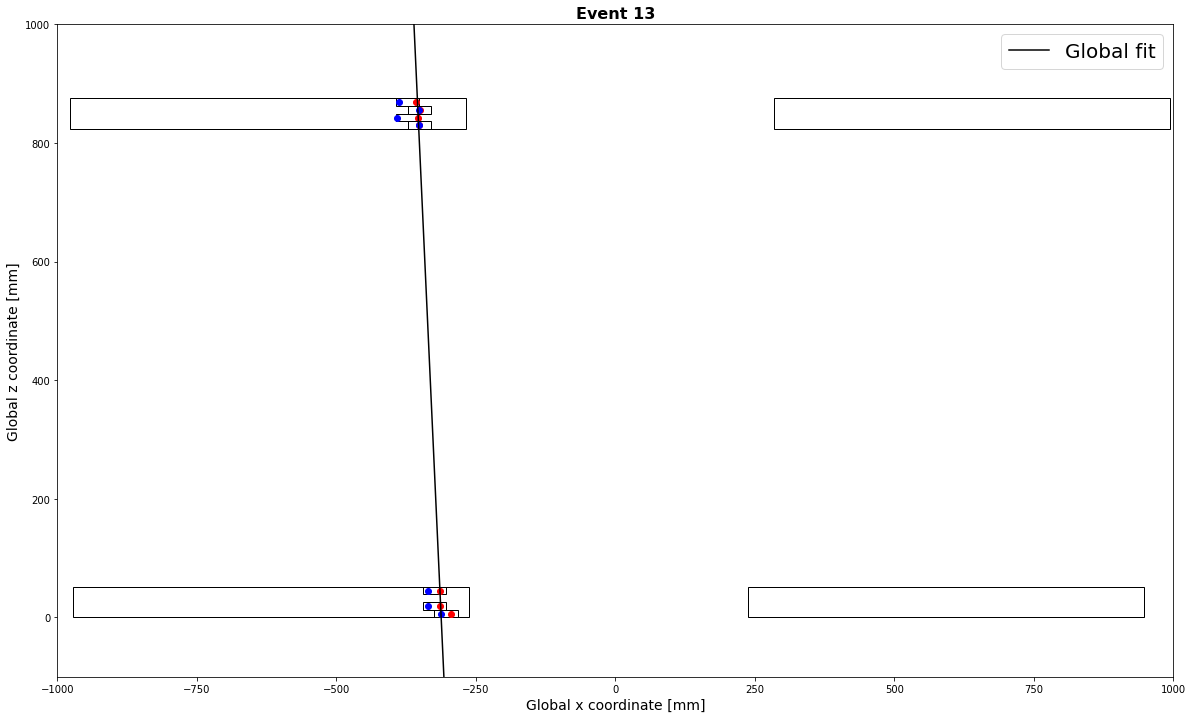

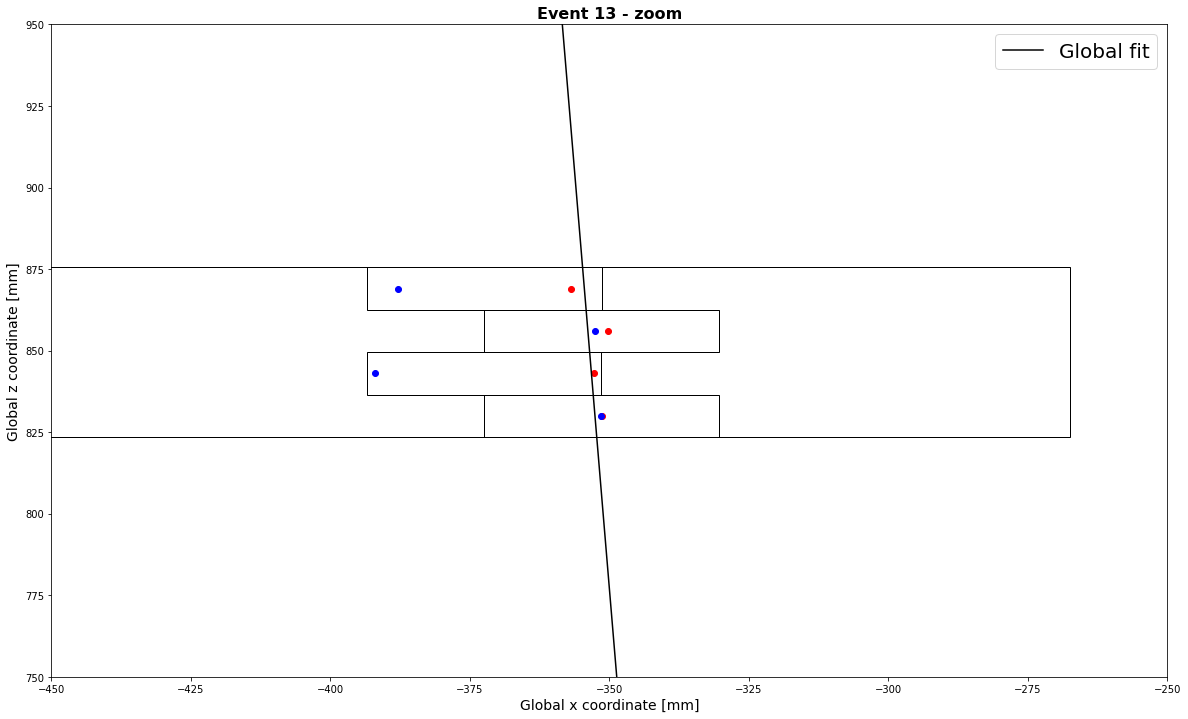

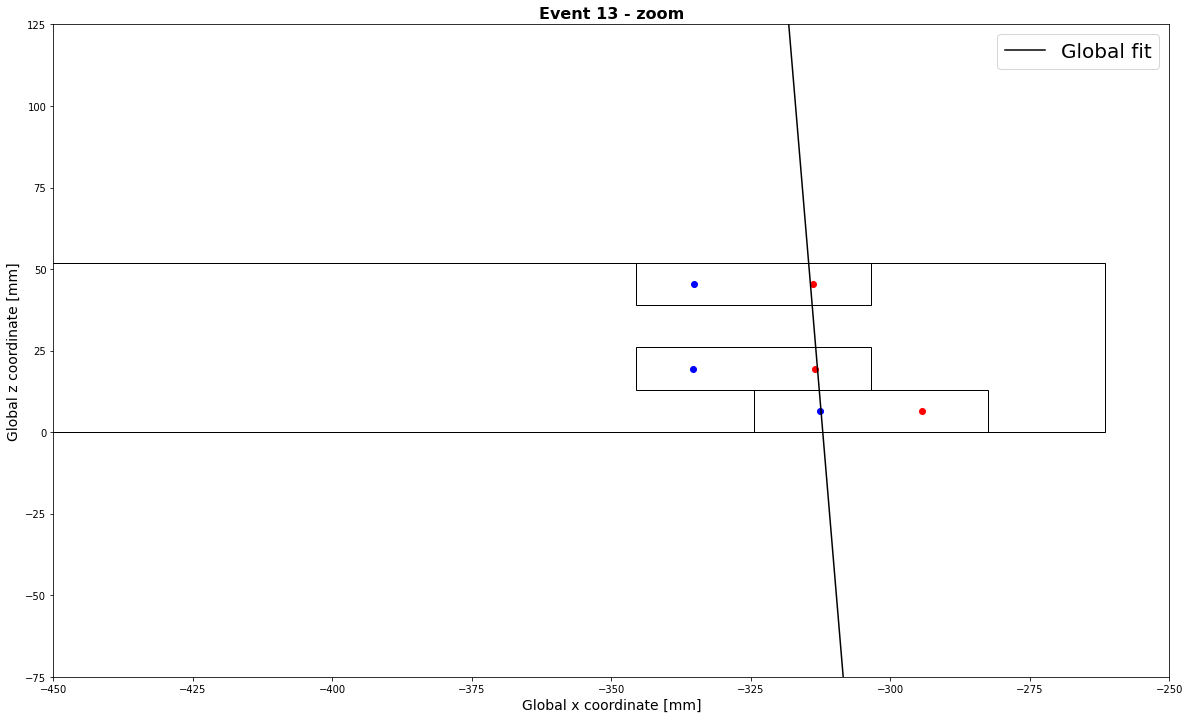

In [22]:
#Example 
print(f"Example: event {evt_number}\n")
start_time = timeit.default_timer()
best_global_fit = find_best_global_combination_and_fit(best_events[evt_number])
elapsed = timeit.default_timer() - start_time
print("Execution time: ", elapsed, "s\n")

       
print("Results: \n")
for i in best_global_fit:
    print(i, "=", best_global_fit[i])

mtotfit2=best_global_fit["Parameters (m,q)"][0]
qtotfit2=best_global_fit["Parameters (m,q)"][1]


fig, ax = exp_setup(best_events, evt_number, [-1000,1000], [-100,1000], mtot=mtotfit2, qtot=qtotfit2  )

fig, ax = exp_setup(best_events, evt_number, [-450,-250], [750,950], mtot=mtotfit2, qtot=qtotfit2  )
fig, ax = exp_setup(best_events, evt_number, [-450,-250], [-75,125], mtot=mtotfit2, qtot=qtotfit2  )



### Comparison of the two methods

The plots show that Method 2 (global optimization) prevents unphysical outcomes and grants the correct determination of the best coordinates combination also in cases in which Method 1 (local optimization) fails.

As previously observed, the drawback of performing a global optimization is that it is less efficient from the computational point of view: in facts, global optimization is about four time slower than local optimization and global fit of the found points.

With 6-8 points, the global minimization is still feasable; if the number of combination is further increased, a more efficient method must be found.


A possible solution could be to perform the local optimization, but imposing an extra condition on the maximum slope of each local fit.
The maximum angle of the trajectory can be determined by imposing the line to cross both the hits distributions, in the two detectors.
In this way, the global constraint to the fit function is taken into account, still without performing a real global optimization.
The maximum angle, though, must be estimated event by event considering the hits distribution in the two detector, so the efficiency of the method becomes comparable with the global optimization.


In the following analysis, Method 2 will be employed to determine the tracks of the muons.

**Comment**

In facts, the global fit of the locally optimized points gives similar results with respect to the one coming from global optimization: even if for some layers the wrong coordinate is chosen (left instead of right or viceversa), the global fit is still approximately correct.

Therefore, Method 1, even without implementing the additional condition on the slope, works well enough if the objective is to determine the overall track of the muon; instead, it fails in determining precisely the hits coordinates, namely in removing the left/right ambiguity layer by layer.




# Analysis of all the run data files
We can now apply the complete analysis to all the data files available. To do so, the functions introduced and explained in the previous sections are recalled. 

RUN  260 : E =  22  GeV, I =  -580  A 

 - DATA STORAGE AND COORDINATE TRANSFORMATION: 
Events successfully stored in list of DataFrames
Total number of events:  4833

 - EVENTS FILTERING AND SELECTION: 
Event filtering - step 1:
Number of events with hits only in two aligned detectors (left OR right): 2868 

Event filtering - step 2:
Number of events without multiple hits per layer: 1767 

Event filtering - step 3:
Number of events with at least 3 hit layers for each detector: 1457 

Event filtering - step 4:
Number of events on the left arm:  1363
Number of events on the right arm:  94
The maximum is on the left, so we reject events on detectors 0 and 1
The number of events on the left is indeed  14.5  times larger than the number of events on the right 

For this run: 
 - Detector up:  2 
 - Detector down:  3 



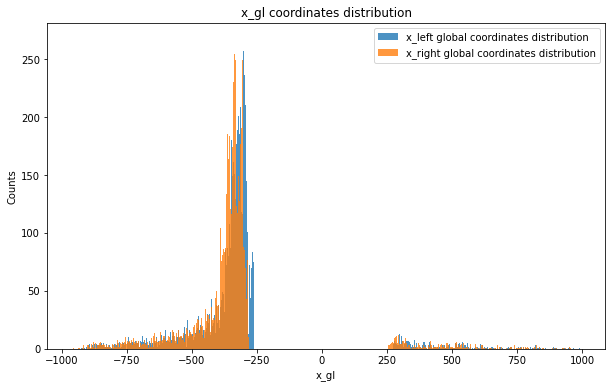

Event filtering - step 5:
Parameters fit function detector up: 
 Amplitude =  169.09 
 Sigma =  35.34 
 Centroid =  -347.37 


Parameters fit function detector down: 
 Amplitude =  180.06 
 Sigma =  29.91 
 Centroid =  -307.97 




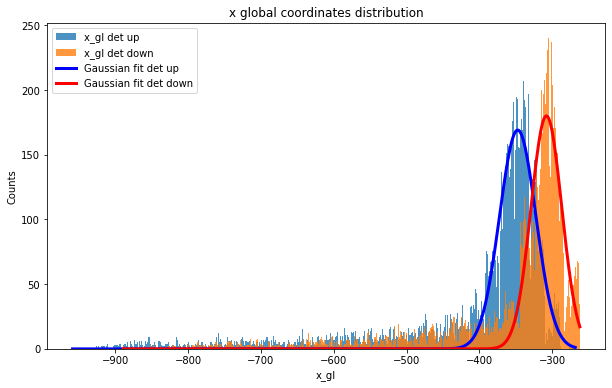

Number of events within 5sigma from the center of the distributions:  1054
...........................................................................................................

The percentage of selected events is:  21.81 %
Angle of incidence of the track with respect to z axis:  2.74 °
...........................................................................................................

 - TRACKS FIT: 
Example of track reconstruction via global optimization


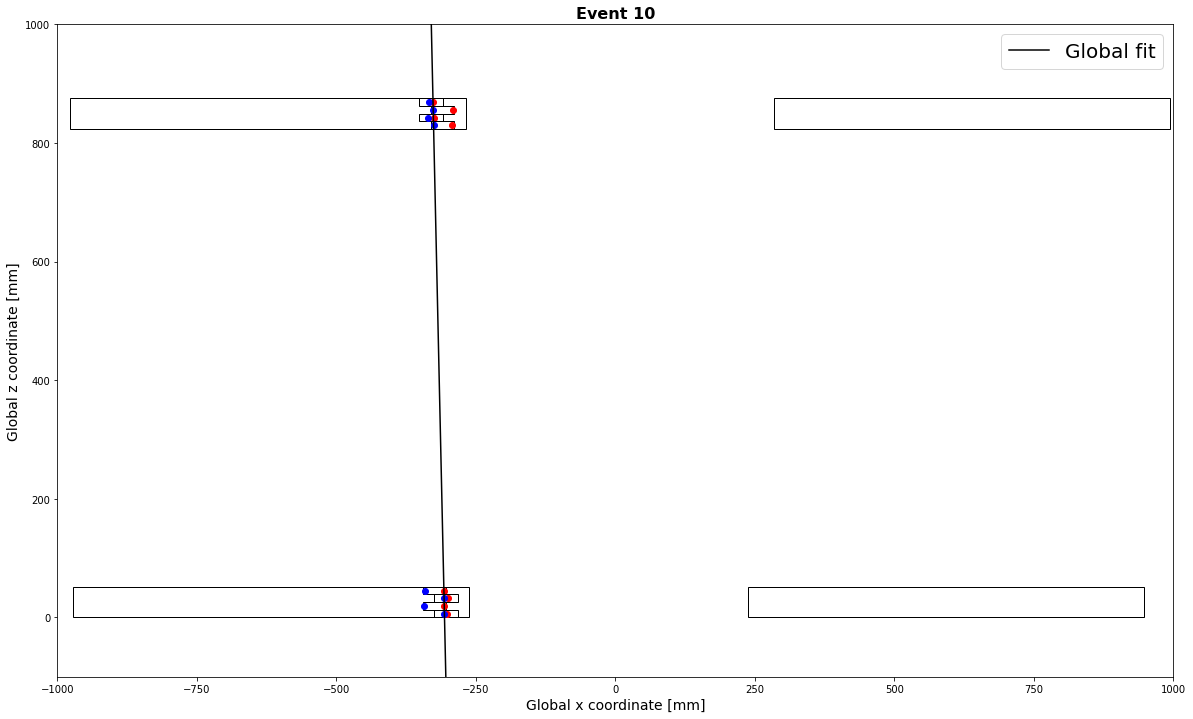

Execution time global optimization:  129.62755261198618 s


RUN  261 : E =  18  GeV, I =  -850  A 

 - DATA STORAGE AND COORDINATE TRANSFORMATION: 
Events successfully stored in list of DataFrames
Total number of events:  2333

 - EVENTS FILTERING AND SELECTION: 
Event filtering - step 1:
Number of events with hits only in two aligned detectors (left OR right): 1765 

Event filtering - step 2:
Number of events without multiple hits per layer: 1171 

Event filtering - step 3:
Number of events with at least 3 hit layers for each detector: 1053 

Event filtering - step 4:
Number of events on the left arm:  1025
Number of events on the right arm:  28
The maximum is on the left, so we reject events on detectors 0 and 1
The number of events on the left is indeed  36.6  times larger than the number of events on the right 

For this run: 
 - Detector up:  2 
 - Detector down:  3 



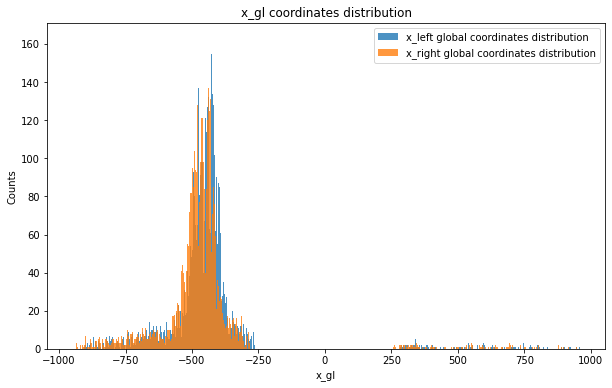

Event filtering - step 5:
Parameters fit function detector up: 
 Amplitude =  107.95 
 Sigma =  43.32 
 Centroid =  -483.06 


Parameters fit function detector down: 
 Amplitude =  113.00 
 Sigma =  37.07 
 Centroid =  -427.62 




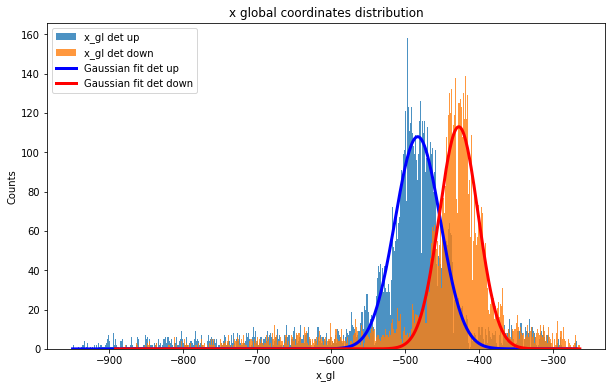

Number of events within 5sigma from the center of the distributions:  892
...........................................................................................................

The percentage of selected events is:  38.23 %
Angle of incidence of the track with respect to z axis:  3.85 °
...........................................................................................................

 - TRACKS FIT: 
Example of track reconstruction via global optimization


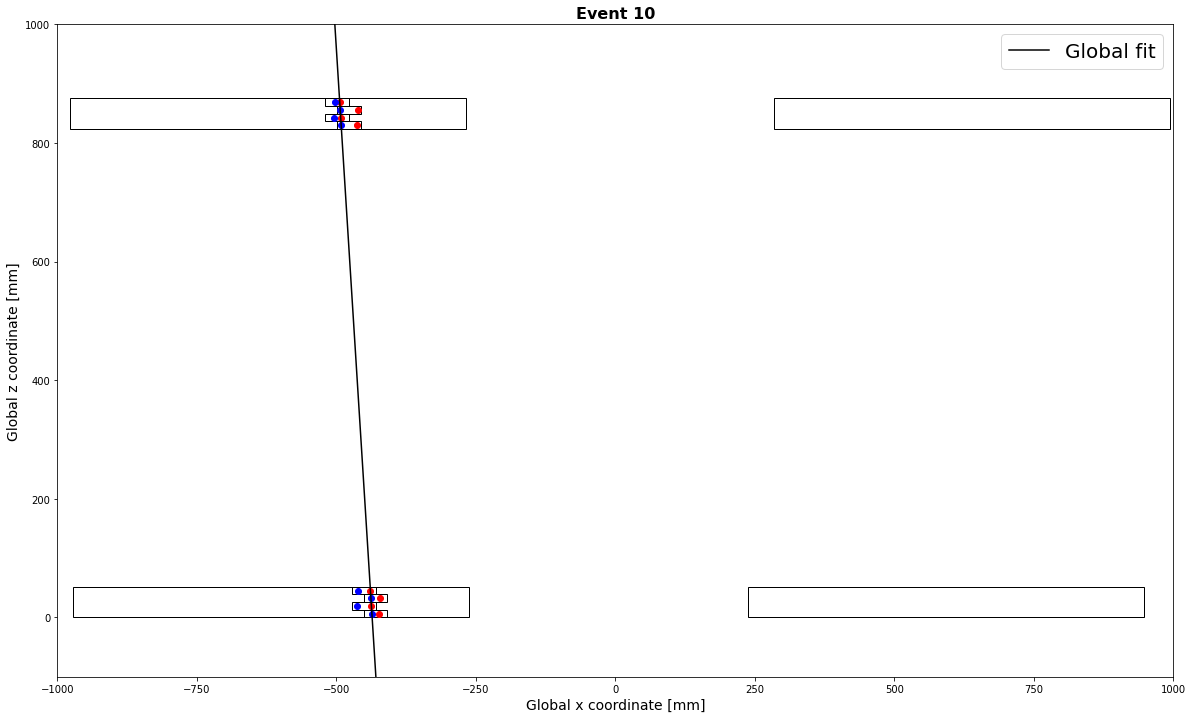

Execution time global optimization:  108.62211618100991 s


RUN  262 : E =  18  GeV, I =  850  A 

 - DATA STORAGE AND COORDINATE TRANSFORMATION: 
Events successfully stored in list of DataFrames
Total number of events:  2995

 - EVENTS FILTERING AND SELECTION: 
Event filtering - step 1:
Number of events with hits only in two aligned detectors (left OR right): 1926 

Event filtering - step 2:
Number of events without multiple hits per layer: 1222 

Event filtering - step 3:
Number of events with at least 3 hit layers for each detector: 1104 

Event filtering - step 4:
Number of events on the left arm:  31
Number of events on the right arm:  1073
The maximum is on the right arm, so we reject events on detectors 2 and 3
The number of events on the right is indeed  34.6  times larger than the number of events on the left 

For this run: 
 - Detector up:  0 
 - Detector down:  1 



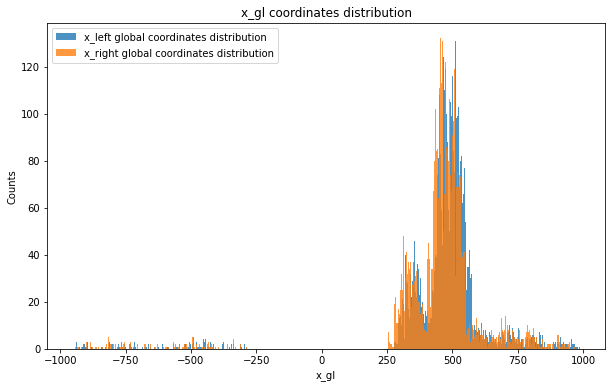

Event filtering - step 5:
Parameters fit function detector up: 
 Amplitude =  101.27 
 Sigma =  41.60 
 Centroid =  513.95 


Parameters fit function detector down: 
 Amplitude =  115.22 
 Sigma =  37.17 
 Centroid =  457.84 




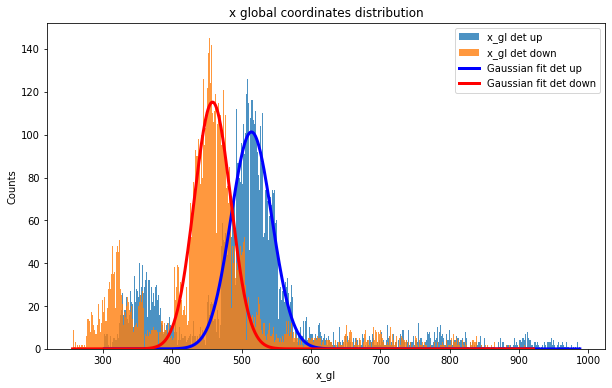

Number of events within 5sigma from the center of the distributions:  852
...........................................................................................................

The percentage of selected events is:  28.45 %
Angle of incidence of the track with respect to z axis:  3.90 °
...........................................................................................................

 - TRACKS FIT: 
Example of track reconstruction via global optimization


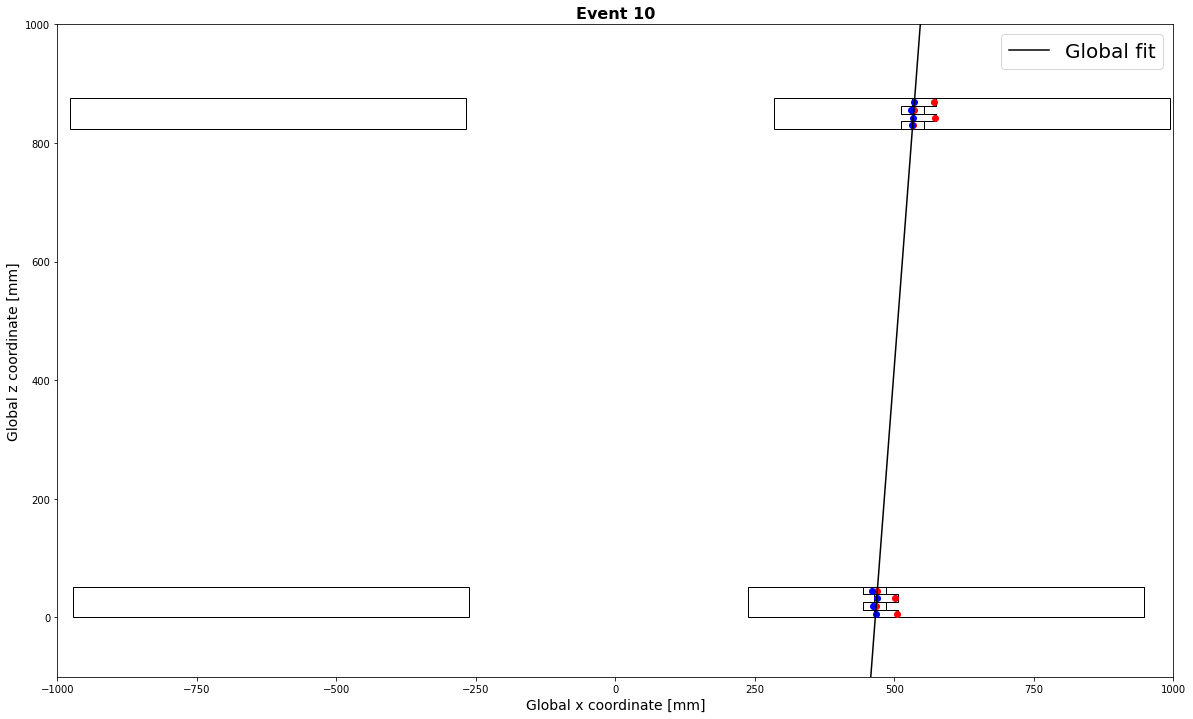

Execution time global optimization:  103.25580974400509 s


RUN  263 : E =  22  GeV, I =  580  A 

 - DATA STORAGE AND COORDINATE TRANSFORMATION: 
Events successfully stored in list of DataFrames
Total number of events:  552

 - EVENTS FILTERING AND SELECTION: 
Event filtering - step 1:
Number of events with hits only in two aligned detectors (left OR right): 411 

Event filtering - step 2:
Number of events without multiple hits per layer: 292 

Event filtering - step 3:
Number of events with at least 3 hit layers for each detector: 237 

Event filtering - step 4:
Number of events on the left arm:  42
Number of events on the right arm:  195
The maximum is on the right arm, so we reject events on detectors 2 and 3
The number of events on the right is indeed  4.6  times larger than the number of events on the left 

For this run: 
 - Detector up:  0 
 - Detector down:  1 



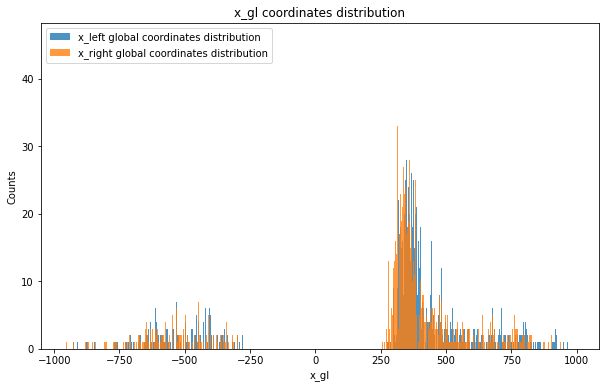

Event filtering - step 5:
Parameters fit function detector up: 
 Amplitude =  20.84 
 Sigma =  33.43 
 Centroid =  367.32 


Parameters fit function detector down: 
 Amplitude =  19.15 
 Sigma =  35.50 
 Centroid =  330.85 




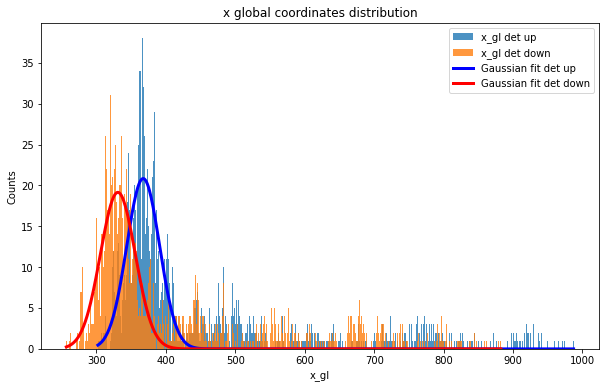

Number of events within 5sigma from the center of the distributions:  141
...........................................................................................................

The percentage of selected events is:  25.54 %
Angle of incidence of the track with respect to z axis:  2.54 °
...........................................................................................................

 - TRACKS FIT: 
Example of track reconstruction via global optimization


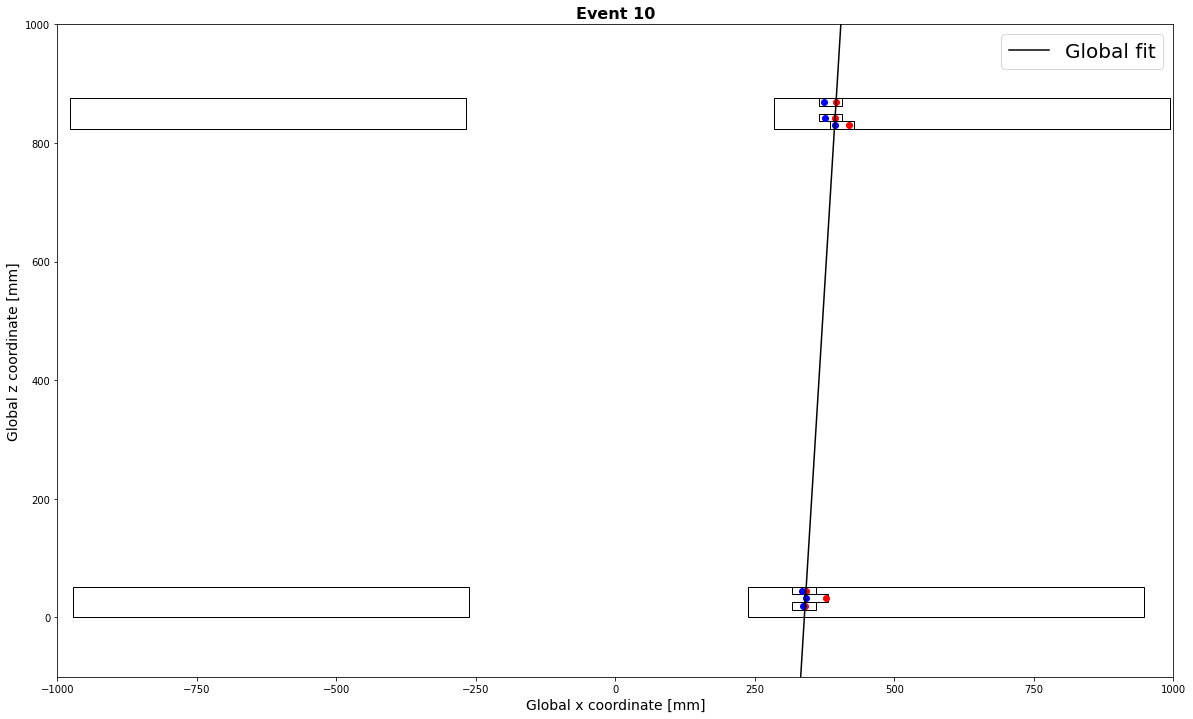

Execution time global optimization:  16.33511658399948 s




In [23]:

file_names = ["data_run260.txt",
             "data_run261.txt",
             "data_run262.txt",
             "data_run263.txt"]

#Initialization of parameters for gaussian fit
p1 = [[250, 100, -300], [120, 50, -500], [120, 50, 500], [120, 50, 400]]
p2 = [[200, 100, -350], [120, 50, -400], [120, 50, 400], [120, 50, 300]]

#Lists with parameters of each run
run = [260, 261, 262, 263]
energy = [22, 18, 18, 22]
current = [-580, -850, 850, 580]

#Index of the event that will be plot as an example
evt_to_plot = 10 

for (input_file, i) in zip(file_names, range(4)):

    print("RUN ", run[i], ": E = ", energy[i], " GeV, I = ", current[i], " A \n")

    # DATA STORAGE AND COORDINATE TRANSFORMATION
    print(" - DATA STORAGE AND COORDINATE TRANSFORMATION: ")
    events = read_data(input_file)
    N_ev_i = len(events)
    
    # EVENTS FILTERING AND SELECTION
    print("\n - EVENTS FILTERING AND SELECTION: ")
    good_events1= event_filtering1(events)
    good_events2 = event_filtering2(good_events1)
    good_events3 = event_filtering3(good_events2)
    good_events4, det_up, det_down = event_filtering4(good_events3)
    good_events5, centr_up, centr_down = event_filtering5(good_events4, det_up, det_down, p1[i], p2[i])
    best_events = good_events5
    N_ev_f = len(best_events)

    print("...........................................................................................................\n")
    print("The percentage of selected events is: ", format((N_ev_f/N_ev_i)*100, ".2f"), "%")

    #ANGLE
    theta_z = deflection_angle(centr_up, centr_down)
    print("...........................................................................................................")
    
    #TRACKS FIT
    print("\n - TRACKS FIT: ")
    
    #Chosen method: global optimization
    print("Example of track reconstruction via global optimization")
    start_time = timeit.default_timer()
    for j in range(len(best_events)):
        best_global_fit = find_best_global_combination_and_fit(best_events[j])
        if j==evt_to_plot:
            mtotfit2=best_global_fit["Parameters (m,q)"][0]
            qtotfit2=best_global_fit["Parameters (m,q)"][1]
            fig, ax = exp_setup(best_events, evt_to_plot, [-1000,1000], [-100,1000], mtot=mtotfit2, qtot=qtotfit2  )
    elapsed = timeit.default_timer() - start_time
    print("Execution time global optimization: ", elapsed, "s\n")


    print("============================================================================================================")
    print("============================================================================================================\n")





# Conclusions 

The project here presented was focused on the analysis of calibration runs obtained using a monoenergetic beam of positive muons, deflected by a dipole magnet. 
The main goal was to filter all the events recorded and to reconstruct the real physical trajectory of the particles bended by the magnet. 

For each run we can summarize the percentage of selected events with respect to initial events, after the application of the rejection procedure and the deflection angle of the particle trajectory for the given value of magnet current:

| Run |  Energy (GeV)| Magnet current (A) | Selected events (%)|   Deflection angle |
|-----|:-----:|:-----:|:----:|:----:|
| 260 | 22 |  -580 | 21.81 %   | 2.74 ° |     
| 261 | 18 |  -850 | 38.23 %   | 3.85 ° |     
| 262 | 18 |   850 | 28.45 %   | 3.90 ° |     
| 263 | 22 |   580 | 25.54 %   | 2.54 ° |      



In order to find the trajectory of the particle traversing the detector all the possible combinations between the _xleft_ and _xright_ coordinates have been then studied. 
Looking at the results obtained it is possible to infer that the analysis performed is able to find the right path followed by the particle for each of the calibration run acquired. 

